# Pricing options and computing implied volatilities
# using neural networks (*Article*)

Qiyao Zhou et Yibo Wang

2025 - 1 - 8

In [1]:
# Importations de base
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import qmc
# utiliser le module QMC (quasi-monte carlo) pour l'échantillonnage en hypercube latin


# Importations pour PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, LambdaLR


# Importation des métriques d'évaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score


# Importation pour visualiser le résultats de MonteCarlo
import pandas as pd


# Importation pour évaluer l'efficacité
import time
from scipy import optimize


# Importation pour visualiser la surface de volatilité
from scipy import interpolate

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# 1) Réseau de valorisation Black-Scholes : BS-ANN

### Formule Fermé de Black-Scholes

La valeur d'une option est donnée par la formule suivante :

$$
V(t, S) = S\mathcal{N}(d_1) - Ke^{-r(T-t)}\mathcal{N}(d_2)
$$

où :

$$
d_1 = \frac{\log(S/K) + \left(r - 0.5\sigma^2\right)(T-t)}{\sigma\sqrt{T-t}}, \quad
d_2 = d_1 - \sigma\sqrt{T-t}
$$

In [3]:
def calculer_d1_d2(x, tau, r, sigma):
    """
    Calcul de d1 et d2 pour le modèle Black-Scholes.
    x : rapport S/K ou moneyness
    tau : temps jusqu'à maturité (T - t)
    r : taux d'intérêt sans risque
    sigma : volatilité
    Retourne : d1, d2
    """
    sqrt_tau = np.sqrt(tau)
    d1 = (np.log(x) + (r + 0.5 * sigma ** 2) * tau) / (sigma * sqrt_tau)
    d2 = d1 - sigma * sqrt_tau
    return d1, d2

In [4]:
def BS_price_call(S, K, T, t, r, sigma):
    """
    Valeur d'une option call selon le modèle Black-Scholes.
    S : prix spot
    K : prix de strike
    T : échéance
    t : temps actuel
    r : taux d'intérêt sans risque
    sigma : volatilité
    Retourne : le prix de l'option
    """
    if T == t:  
        return np.maximum(0, S - K)

    d1, d2 = calculer_d1_d2(S / K, T - t, r, sigma)
    value = S * norm.cdf(d1) - K * np.exp(-r * (T - t)) * norm.cdf(d2)
    return value

def BS_moneyness_call(moneyness, tau, r, sigma):
    """
    Valeur d'une option call exprimée en termes de moyeness.
    moneyness : S/K
    tau : temps jusqu'à maturité
    r : taux d'intérêt
    sigma : volatilité
    Retourne : V/K
    """
    d1, d2 = calculer_d1_d2(moneyness, tau, r, sigma)
    value_moneyness = moneyness * norm.cdf(d1) - np.exp(-r * tau) * norm.cdf(d2)
    return value_moneyness


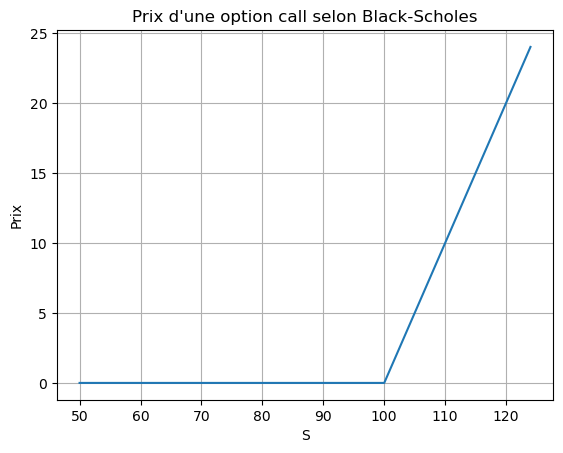

In [5]:
# Vérification des prix des options par rapport aux S
r, T, t, sigma, K, S = 0.05, 1, 1, 0.3, 100, np.arange(50,125)
plt.plot(S, BS_price_call(S, K, T, t, r, sigma))
plt.xlabel("S")
plt.ylabel("Prix")
plt.title("Prix d'une option call selon Black-Scholes" )
plt.grid()

### 1.Génération de données

In [6]:
def BS_LHS_data_generator(n=10**6, low_bounds=[0.4, 0.2, 0.02, 0.01], up_bounds=[1.6, 1.1, 0.1, 1]):
    """
    Génère des échantillons de prix d'options call en utilisant un échantillonnage en hypercube latin.
    Retourne un tenseur torch float de dimension (n,5) contenant les échantillons d'entrée et les valeurs des options.
    Les entrées sont : Moneyness (S/K), temps jusqu'à maturité (tau, T-t), taux sans risque (r), volatilité (sigma).
    
    n : nombre d'échantillons.
    low_bounds : bornes inférieures pour les entrées.
    up_bounds : bornes supérieures pour les entrées. (selon l'article)

    """
    sample_ = qmc.LatinHypercube(d=4)
    sample = qmc.scale(sample_.random(n), low_bounds, up_bounds)
    bs_prices = BS_moneyness_call(sample[:, 0], sample[:, 1], sample[:, 2], sample[:, 3]).reshape((-1, 1))
    bs_dataset = np.concatenate((sample, bs_prices), axis=1)

    bounds_labels = ["S/K", "Tau", "r", "Sigma", "V/K"]
    print("------ INPUT ------")
    for i, label in enumerate(bounds_labels[:-1]):
        print(f"{label:<12} [{min(bs_dataset[:, i]):.2f} {max(bs_dataset[:, i]):.2f}]")
    print("------ OUTPUT ------")
    print(f"{bounds_labels[-1]:<12} [{min(bs_dataset[:, -1]):.2f} {max(bs_dataset[:, -1]):.2f}]")

    return torch.FloatTensor(bs_dataset)

# Test de la fonction
bs_dataset = BS_LHS_data_generator()

------ INPUT ------
S/K          [0.40 1.60]
Tau          [0.20 1.10]
r            [0.02 0.10]
Sigma        [0.01 1.00]
------ OUTPUT ------
V/K          [0.00 0.90]


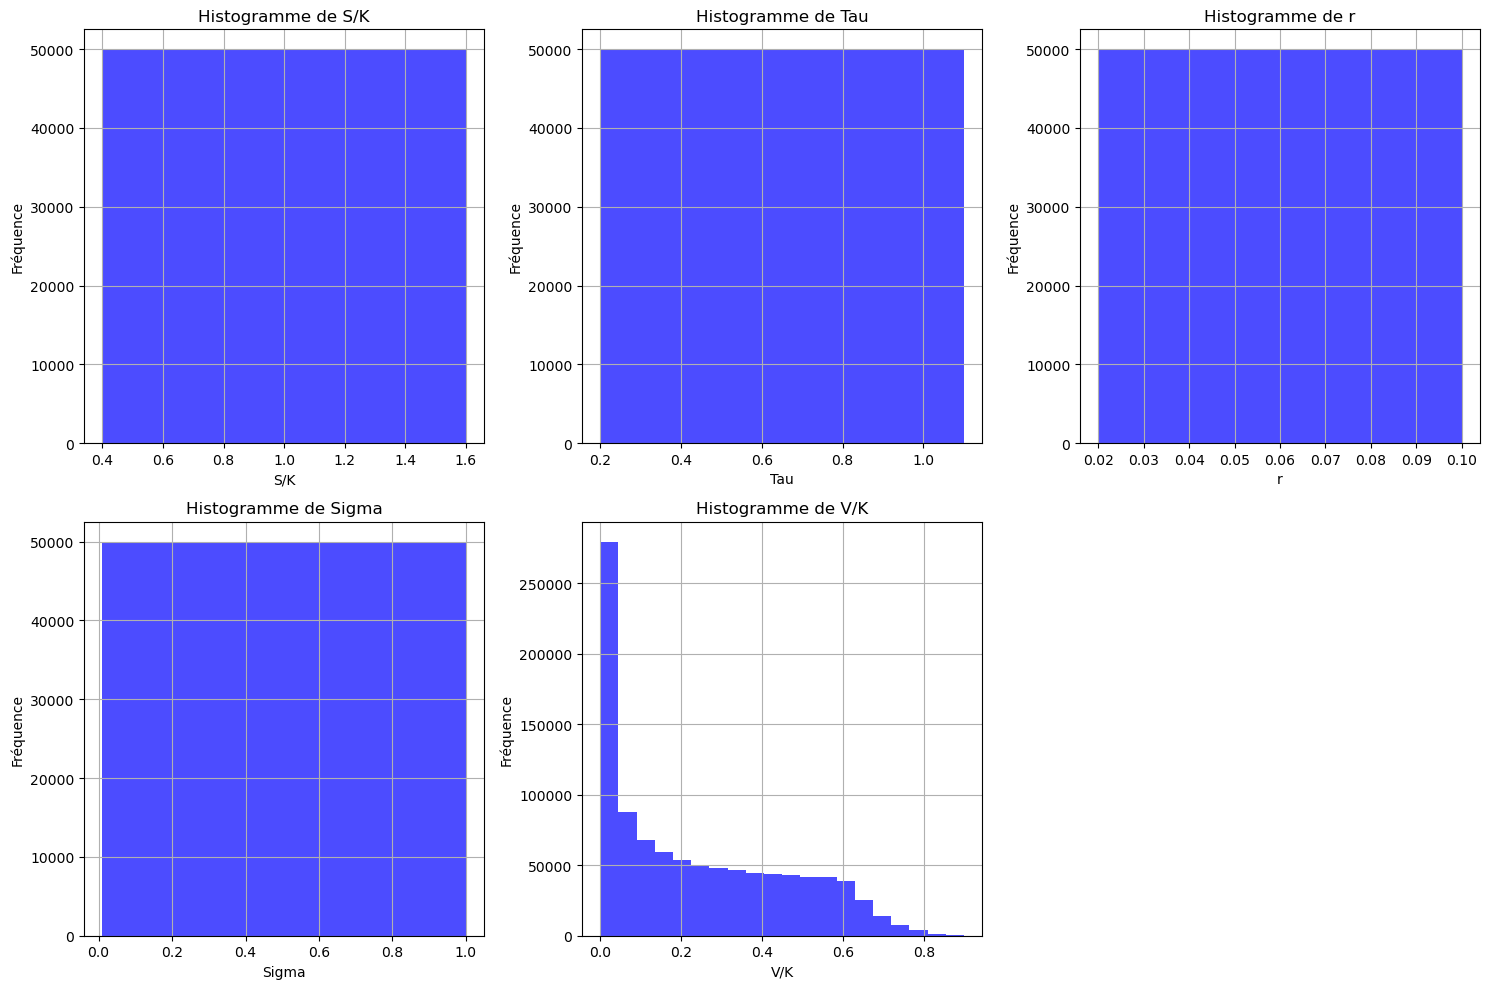

In [7]:
# Verifer les distributions des parametres
parameters = ["S/K", "Tau", "r", "Sigma", "V/K"]
n_params = len(parameters)

plt.figure(figsize=(15, 10))
for i in range(n_params):
    plt.subplot(2, 3, i + 1)  
    plt.hist(bs_dataset[:, i], bins=20, color='blue', alpha=0.7)
    plt.xlabel(parameters[i])
    plt.ylabel("Fréquence")
    plt.title(f"Histogramme de {parameters[i]}")
    plt.grid()


if n_params < 6:
    for j in range(n_params + 1, 7):
        plt.subplot(2, 3, j)
        plt.axis('off')  

plt.tight_layout()
plt.show()


### 2.Définir Class BS-ANN

In [8]:
class BS_ANN(nn.Module):
    def __init__(self):
        """
        Initialise le réseau BS-ANN avec 4 couches cachées, 400 neurons per couche.
        Les poids sont initialisés avec Glorot_uniform (Xavier_uniform). 
        Les hyperparametres sont determines par 'random search'. (selon l'article)
        """
        super(BS_ANN, self).__init__()
        self.layers = nn.ModuleList([
            nn.Linear(4, 400),
            nn.Linear(400, 400),
            nn.Linear(400, 400),
            nn.Linear(400, 400),
            nn.Linear(400, 1)
        ])
        self._initialize_weights()

    def _initialize_weights(self):
        """
        Initialise les poids de toutes les couches en utilisant Xavier_uniform.
        """
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                torch.nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        """
        Passage avant (forward pass) du réseau.
        Utilise l'activation ReLU, sauf pour la couche finale.
        """
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        return self.layers[-1](x).flatten()

    def _log_training(self, epoch, batch_idx, train_loader, loss, args):
        """
        Affiche les informations de journalisation pendant l'entraînement.
        """
        print(f'Train Epoch: {epoch} [{batch_idx * len(train_loader.dataset) // len(train_loader)}/'
      f'{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\t'
      f'log Loss: {np.log(loss):.6f}')


    def train_model(self, args, device, train_loader, optimizer, epoch):
        """
        Entraîne le modèle pour une époque.
        Retourne la perte moyenne de l'ensemble d'entraînement.
        """
        self.train()
        train_loss = 0

        for batch_idx, data in enumerate(train_loader):
            inputs, targets = data[:, :-1].to(device), data[:, -1].to(device)
            optimizer.zero_grad()
            output = self(inputs)
            loss = F.mse_loss(output, targets)
            train_loss += loss.item() * inputs.size(0)
            loss.backward()
            optimizer.step()

            if batch_idx % args["log_interval"] == 0:
                self._log_training(epoch, batch_idx, train_loader, loss.item(), args)
                if args["dry_run"]:
                    break

        train_loss /= len(train_loader.dataset)
        print(f'\nTrain set: Average log loss: {np.log(train_loss):.4f}\n')
        return train_loss

    def test_model(self, device, test_loader):
        """
        Teste le modèle sur un ensemble de données de test.
        Retourne la perte moyenne.
        """
        self.eval()
        test_loss = 0

        with torch.no_grad():
            for data in test_loader:
                inputs, targets = data[:, :-1].to(device), data[:, -1].to(device)
                output = self(inputs)
                test_loss += F.mse_loss(output, targets, reduction='sum').item()

        test_loss /= len(test_loader.dataset)
        print(f'\nTest set: Average loss: {np.log(test_loss):.4f}\n')
        return test_loss

### 2.Préparation de l'entrainement

In [9]:
# Définition des paramètres d'entraînement pour determiner le 'learning rate' optimal.
args = {
    "batch_size": 1024,
    "test_batch_size": 1024,
    "epochs": 200,
    "lr": 1,
    "gamma": 1,
    "no_cuda": False,
    "run_dry": False,
    "seed": 0,
    "log_interval": 10**6,
    "dry_run": False,
    "save_model": False,
}

use_cuda = not args["no_cuda"] and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Chargement des données Train / Test
bs_dataset = BS_LHS_data_generator(n = 3*10**4, low_bounds=[0.4, 0.2, 0.02, 0.01], up_bounds=[1.6, 1.1, 0.1, 1])
train_size, test_size = int(bs_dataset.shape[0]*0.9 ), int(bs_dataset.shape[0]*0.1 )
train_dataset, test_dataset = torch.utils.data.random_split(bs_dataset, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args["batch_size"], shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args["test_batch_size"], shuffle=False)

# Initialisation du modèle et de l'optimiseur
model = BS_ANN().to(device)
optimizer = optim.Adam(model.parameters(), lr=args["lr"])

# Scheduler pour l'augmentation du 'learning rate'
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 10 ** (-9 + epoch * 10 / (args["epochs"] - 1)))
# Ainsi le 'learning rate' évolue de 10**-9 à 10 au long des epoches.

train_losses = []
test_losses = []
lrs = []

# Boucle d'entraînement sur les époques
for epoch in range(1, args["epochs"] + 1):
    current_lr = scheduler.get_last_lr()[0]
    print(f"Current Learning rate: {current_lr:.10f}")
    lrs.append(current_lr)

    # Entraînement et test
    train_loss = model.train_model(args, device, train_loader, optimizer, epoch)
    test_loss = model.test_model(device, test_loader)

    scheduler.step()  
    train_losses.append(train_loss)
    test_losses.append(test_loss)

------ INPUT ------
S/K          [0.40 1.60]
Tau          [0.20 1.10]
r            [0.02 0.10]
Sigma        [0.01 1.00]
------ OUTPUT ------
V/K          [0.00 0.89]
Current Learning rate: 0.0000000010
Train Epoch: 1 [0/27000 (0%)]	log Loss: -3.002801

Train set: Average log loss: -2.9962


Test set: Average loss: -2.9552

Current Learning rate: 0.0000000011
Train Epoch: 2 [0/27000 (0%)]	log Loss: -2.997881

Train set: Average log loss: -2.9962


Test set: Average loss: -2.9553

Current Learning rate: 0.0000000013
Train Epoch: 3 [0/27000 (0%)]	log Loss: -3.037419

Train set: Average log loss: -2.9963


Test set: Average loss: -2.9553

Current Learning rate: 0.0000000014
Train Epoch: 4 [0/27000 (0%)]	log Loss: -2.984809

Train set: Average log loss: -2.9963


Test set: Average loss: -2.9553

Current Learning rate: 0.0000000016
Train Epoch: 5 [0/27000 (0%)]	log Loss: -3.034926

Train set: Average log loss: -2.9963


Test set: Average loss: -2.9554

Current Learning rate: 0.0000000018
Tra

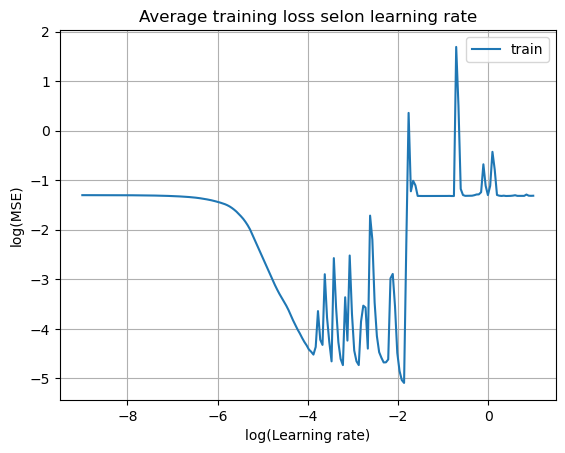

In [10]:
plt.plot(np.log10(lrs), np.log10(train_losses), label = "train")
plt.xlabel("log(Learning rate)")
plt.ylabel("log(MSE)")
plt.title("Average training loss selon learning rate" )
plt.grid()
plt.legend()

>###  Nous avons identifié l'intervalle où le learning rate diminue le plus rapidement : $[10^{-6}, 10^{-4}]$.

###  3.L'entrainement du BS_ANN : On va directement appliquer ce résultat pour 
###    l'entrainement du BS-ANN avec DecayLR. (Wide dataset)

In [11]:
# Paramètres d'entraînement
args = {
    "batch_size": 1024,
    "test_batch_size": 4048,
    "epochs": 3000,  
    "lr": 1e-4,
    "gamma": 0.1,  # Réduction du 'learning rate' 
    "run_dry": False,
    "log_interval": 100,
    "dry_run": False,
    "seed": 0,
    "no_cuda": False,
    "save_model": True,
}


# Configuration du périphérique (GPU ou CPU)
use_cuda = not args["no_cuda"] and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Chargement des données d'entraînement et de test
bs_dataset = BS_LHS_data_generator(n=2*10**5) # "size of training data" vient du l'article
train_size = int(bs_dataset.shape[0] * 0.9) # 90% pour l'entraînement
test_size = bs_dataset.shape[0] - train_size # 10% pour le test
train_dataset, test_dataset = torch.utils.data.random_split(bs_dataset, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args["batch_size"], shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args["test_batch_size"], shuffle=False)

# Initialisation du modèle, de l'optimiseur et du scheduler
print(device)
model = BS_ANN().to(device)
optimizer = optim.Adam(model.parameters(), lr=args["lr"])  # Optimiseur Adam
scheduler = StepLR(optimizer, step_size=1000, gamma=args["gamma"])  # Réduction du LR tous les 1000 époques

train_losses = []
test_losses = []

# Boucle d'entraînement
for epoch in range(1, args["epochs"] + 1):
    train_loss = model.train_model(args, device, train_loader, optimizer, epoch)
    test_loss = model.test_model(device, test_loader)
    
    # Affichage du taux d'apprentissage actuel
    print(f"Current Learning Rate: {scheduler.get_last_lr()[0]:.6e}")
    scheduler.step()
    
    # Enregistrement des pertes
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Sauvegarde du modèle entraîné
if args["save_model"]:
    torch.save(model.state_dict(), "BS_ANN.pt")


------ INPUT ------
S/K          [0.40 1.60]
Tau          [0.20 1.10]
r            [0.02 0.10]
Sigma        [0.01 1.00]
------ OUTPUT ------
V/K          [0.00 0.89]
cuda
Train Epoch: 1 [0/180000 (0%)]	log Loss: -2.964441
Train Epoch: 1 [102272/180000 (57%)]	log Loss: -7.488057

Train set: Average log loss: -5.5031


Test set: Average loss: -8.7252

Current Learning Rate: 1.000000e-04
Train Epoch: 2 [0/180000 (0%)]	log Loss: -8.746846
Train Epoch: 2 [102272/180000 (57%)]	log Loss: -9.750095

Train set: Average log loss: -9.5039


Test set: Average loss: -10.0739

Current Learning Rate: 1.000000e-04
Train Epoch: 3 [0/180000 (0%)]	log Loss: -10.083110
Train Epoch: 3 [102272/180000 (57%)]	log Loss: -10.485554

Train set: Average log loss: -10.4411


Test set: Average loss: -10.8917

Current Learning Rate: 1.000000e-04
Train Epoch: 4 [0/180000 (0%)]	log Loss: -10.898544
Train Epoch: 4 [102272/180000 (57%)]	log Loss: -11.109008

Train set: Average log loss: -10.6780


Test set: Average loss

Training WIDE 1.2185884666532983e-08 VS dans l'article 8.04e-09


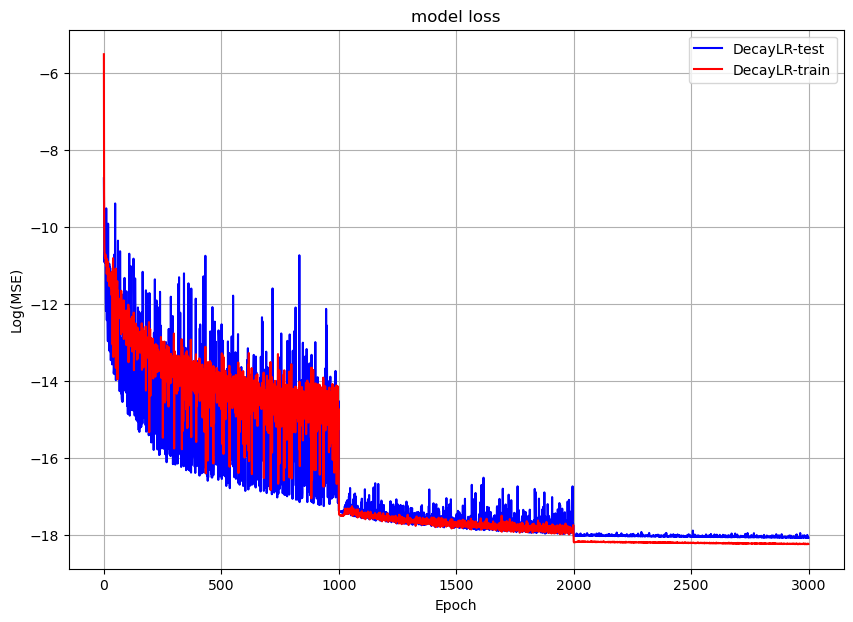

In [12]:
# Plot Log(MSE) selon epoch
plt.figure(figsize=(10,7))
plt.plot( np.log(test_losses), label = "DecayLR-test", color = 'blue')
plt.plot( np.log(train_losses), label = "DecayLR-train", color = 'red')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Log(MSE)")
plt.title("model loss" )
plt.grid()
print(f"Training WIDE {train_losses[-1]} VS dans l'article 8.04e-09")

>### Le graphique ci-dessus montre qu'il n'y a pas eu de surapprentissage (over-fitting).

### 4.On va maintenant tester et espérer de tirer une conclusion sur les raisons pour lesquelles 
### DecayLR est utilisé plutôt que CyclicalLR ou ConstantLR.

In [13]:
# === Cyclical LR ===
model_cyclical = BS_ANN().to(device)
optimizer_cyclical = optim.Adam(model_cyclical.parameters(), lr=args["lr"])
scheduler_cyclical = torch.optim.lr_scheduler.CyclicLR(
    optimizer_cyclical,
    base_lr=1e-6,
    max_lr=1e-4,
    step_size_up=500,
    mode="triangular"
)

train_losses_cyclical = []
test_losses_cyclical = []

print("\n=== Training with CyclicalLR ===")
for epoch in range(1, args["epochs"] + 1):
    train_loss = model_cyclical.train_model(args, device, train_loader, optimizer_cyclical, epoch)
    test_loss = model_cyclical.test_model(device, test_loader)
    scheduler_cyclical.step()
    train_losses_cyclical.append(train_loss)
    test_losses_cyclical.append(test_loss)


if args["save_model"]:
    torch.save(model_cyclical.state_dict(), "BS_ANN_CyclicalLR.pt")


=== Training with CyclicalLR ===
Train Epoch: 1 [0/180000 (0%)]	log Loss: -2.675961
Train Epoch: 1 [102272/180000 (57%)]	log Loss: -3.040248

Train set: Average log loss: -2.9999


Test set: Average loss: -3.1589

Train Epoch: 2 [0/180000 (0%)]	log Loss: -3.121879
Train Epoch: 2 [102272/180000 (57%)]	log Loss: -3.226601

Train set: Average log loss: -3.2647


Test set: Average loss: -3.3782

Train Epoch: 3 [0/180000 (0%)]	log Loss: -3.435576
Train Epoch: 3 [102272/180000 (57%)]	log Loss: -3.481282

Train set: Average log loss: -3.5106


Test set: Average loss: -3.6625

Train Epoch: 4 [0/180000 (0%)]	log Loss: -3.658958
Train Epoch: 4 [102272/180000 (57%)]	log Loss: -3.884398

Train set: Average log loss: -3.8187


Test set: Average loss: -3.9852

Train Epoch: 5 [0/180000 (0%)]	log Loss: -3.954131
Train Epoch: 5 [102272/180000 (57%)]	log Loss: -4.209808

Train set: Average log loss: -4.1423


Test set: Average loss: -4.3165

Train Epoch: 6 [0/180000 (0%)]	log Loss: -4.272682
Train Epoc

In [14]:
# === Constant LR ===
model_constant = BS_ANN().to(device)
optimizer_constant = optim.Adam(model_constant.parameters(), lr=args["lr"])

train_losses_constant = []
test_losses_constant = []

print("\n=== Training with ConstantLR ===")
for epoch in range(1, args["epochs"] + 1):
    train_loss = model_constant.train_model(args, device, train_loader, optimizer_constant, epoch)
    test_loss = model_constant.test_model(device, test_loader)
    train_losses_constant.append(train_loss)
    test_losses_constant.append(test_loss)

if args["save_model"]:
    torch.save(model_constant.state_dict(), "BS_ANN_ConstantLR.pt")


=== Training with ConstantLR ===
Train Epoch: 1 [0/180000 (0%)]	log Loss: -1.890956
Train Epoch: 1 [102272/180000 (57%)]	log Loss: -6.510699

Train set: Average log loss: -4.7312


Test set: Average loss: -7.9721

Train Epoch: 2 [0/180000 (0%)]	log Loss: -8.032618
Train Epoch: 2 [102272/180000 (57%)]	log Loss: -9.417375

Train set: Average log loss: -8.9718


Test set: Average loss: -9.8079

Train Epoch: 3 [0/180000 (0%)]	log Loss: -9.765981
Train Epoch: 3 [102272/180000 (57%)]	log Loss: -10.364301

Train set: Average log loss: -10.1962


Test set: Average loss: -10.5893

Train Epoch: 4 [0/180000 (0%)]	log Loss: -10.512366
Train Epoch: 4 [102272/180000 (57%)]	log Loss: -10.878992

Train set: Average log loss: -10.8583


Test set: Average loss: -11.1317

Train Epoch: 5 [0/180000 (0%)]	log Loss: -11.147520
Train Epoch: 5 [102272/180000 (57%)]	log Loss: -11.263658

Train set: Average log loss: -11.2580


Test set: Average loss: -11.3941

Train Epoch: 6 [0/180000 (0%)]	log Loss: -11.34729

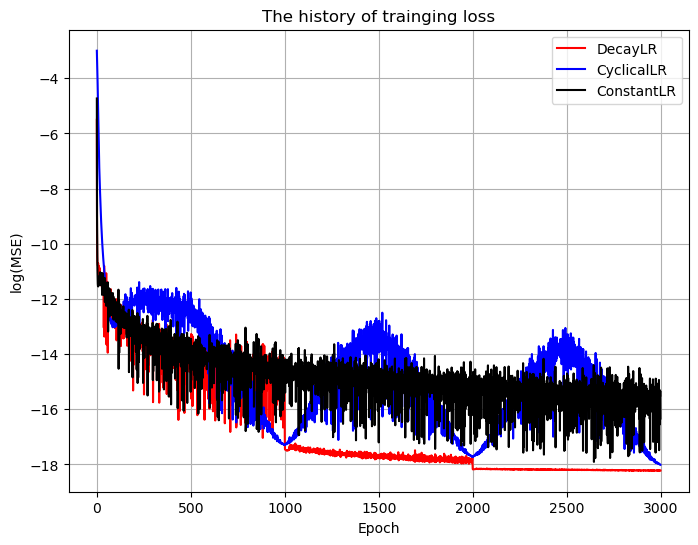

In [15]:
# En comparant les histoires de "training loss" , on a choisi DecayLR pour nos expériences (comme dans l'article).
plt.figure(figsize=(8, 6))

plt.plot(np.log(train_losses), label="DecayLR", color="red")
plt.plot(np.log(train_losses_cyclical), label="CyclicalLR", color="blue")
plt.plot(np.log(train_losses_constant), label="ConstantLR", color="black")

plt.xlabel("Epoch")
plt.ylabel("log(MSE)")
plt.title("The history of trainging loss")
plt.legend()
plt.grid()
plt.show()

In [16]:
# Chargement du modèle BS_ANN
loaded_BS_ANN = BS_ANN().to(device)
PATH = r'C:\Users\qiyao\OneDrive\Desktop\Documents\Documents_M2\ProbaNum avancée\Projet-reproduce\BS_ANN.pt'
loaded_BS_ANN.load_state_dict(torch.load(PATH))
loaded_BS_ANN.eval()

C:\Users\qiyao\AppData\Local\Temp\ipykernel_25744\581470239.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_BS_ANN.load_state_dict(torch.load(PATH))


BS_ANN(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=400, bias=True)
    (1-3): 3 x Linear(in_features=400, out_features=400, bias=True)
    (4): Linear(in_features=400, out_features=1, bias=True)
  )
)

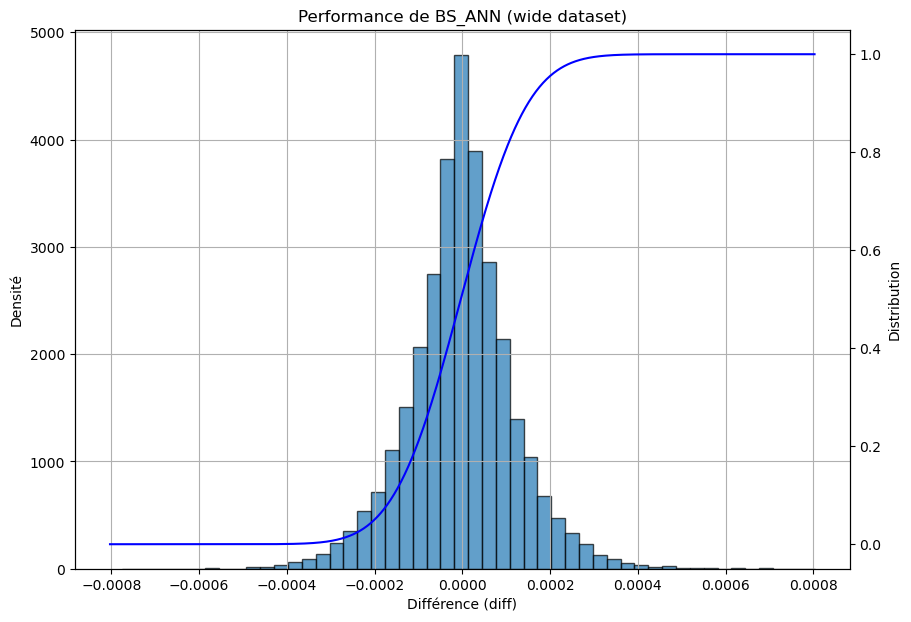

Erreur maximale : 0.00080281496
Erreur minimale : -0.00077603245
Moyenne des erreurs : -3.4438494e-06
Écart-type des erreurs : 0.000119621094


In [17]:
# Calcul des erreurs sur l'ensemble de test
erreurs = []
with torch.no_grad():
    for data in test_loader:
        inputs, targets = data[:, :-1].to(device), data[:, -1].to(device)
        outputs = loaded_BS_ANN(inputs)
        erreurs.append((targets - outputs).cpu().numpy())
    erreurs = np.concatenate(erreurs)

mean_error = erreurs.mean()  # Moyenne des erreurs
std_error = erreurs.std()    # Écart-type des erreurs

# Création des points pour la courbe de distribution cumulative (CDF)
x = np.linspace(-erreurs.max(), erreurs.max(), 1000)
cdf = norm.cdf(x, loc=mean_error, scale=std_error)  

# Visualisation
fig, ax1 = plt.subplots(figsize=(10, 7))

# Histogramme des erreurs
ax1.hist(erreurs, bins=50, density=True, edgecolor='black', alpha=0.7, label="Histogramme des erreurs")
ax1.set_xlabel("Différence (diff)")
ax1.set_ylabel("Densité")
ax1.grid()
ax2 = ax1.twinx()
ax2.plot(x, cdf, 'b-')
ax2.set_ylabel("Distribution")
plt.title("Performance de BS_ANN (wide dataset)")
plt.show()


print("Erreur maximale :", erreurs.max())
print("Erreur minimale :", erreurs.min())
print("Moyenne des erreurs :", mean_error)
print("Écart-type des erreurs :", std_error)


>### La graphique ci-dessus nous donne l'erreur absolue maximale qui est d'environ 0.08% (wide dataset).
>

In [18]:
# Fonction pour calculer les scores d'évaluation
def evaluate_model(loader, model, device):
    """
    Évalue le modèle sur un DataLoader donné (train ou test).
    Retourne les prédictions et les cibles réelles.
    """
    outputs = []
    targets = []
    with torch.no_grad():  # Désactiver le calcul des gradients pour l'évaluation
        for data in loader:
            inputs, target = data[:, :-1].to(device), data[:, -1].to(device)  # Séparer les entrées et les cibles
            output = model(inputs)  # Prédiction du modèle
            outputs.append(output.cpu().numpy())  # Convertir en numpy
            targets.append(target.cpu().numpy())
    return np.concatenate(outputs), np.concatenate(targets)

# Évaluation sur l'ensemble d'entraînement
outputs_train, targets_train = evaluate_model(train_loader, loaded_BS_ANN, device)
print("Scores de training:")
print(f"MSE  : {mean_squared_error(outputs_train, targets_train):e}")
print(f"RMSE : {np.sqrt(mean_squared_error(outputs_train, targets_train)):e}")
print(f"MAE  : {mean_absolute_error(outputs_train, targets_train):e}")
print(f"MAPE : {mean_absolute_percentage_error(outputs_train, targets_train):e}")
print(f"R2   : {r2_score(outputs_train, targets_train):e}")
print("-------------------")

# Évaluation sur l'ensemble de test
outputs_test, targets_test = evaluate_model(test_loader, loaded_BS_ANN, device)
print("Scores de testing:")
print(f"MSE  : {mean_squared_error(outputs_test, targets_test):e}")
print(f"RMSE : {np.sqrt(mean_squared_error(outputs_test, targets_test)):e}")
print(f"MAE  : {mean_absolute_error(outputs_test, targets_test):e}")
print(f"MAPE : {mean_absolute_percentage_error(outputs_test, targets_test):e}")
print(f"R2   : {r2_score(outputs_test, targets_test):e}")

Scores de training:
MSE  : 1.197685e-08
RMSE : 1.094388e-04
MAE  : 8.131270e-05
MAPE : 1.261248e-01
R2   : 9.999998e-01
-------------------
Scores de testing:
MSE  : 1.432106e-08
RMSE : 1.196706e-04
MAE  : 8.810205e-05
MAPE : 1.073629e-01
R2   : 9.999997e-01


### 5.Pour compléter cette partie, on va faire l'entrainement du BS_ANN dans un "narrow dataset" et
### attendre un résultat (un peu) meilleur.

In [19]:
# Paramètres d'entraînement
args = {
    "batch_size": 1024,
    "test_batch_size": 4048,
    "epochs": 3000,  
    "lr": 1e-4,
    "gamma": 0.1,  
    "run_dry": False,
    "log_interval": 100,
    "dry_run": False,
    "seed": 0,
    "no_cuda": False,
    "save_model": True,
}


# Configuration du périphérique (GPU ou CPU)
use_cuda = not args["no_cuda"] and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Chargement des données d'entraînement et de test
low_bounds = [0.5, 0.3, 0.03, 0.02]
up_bounds = [1.5, 0.95, 0.08, 0.9] # le 'narrow dataset' est défini comme ca
bs_dataset = BS_LHS_data_generator(n=2*10**5, low_bounds = low_bounds, up_bounds = up_bounds) # "size of training data" vient du l'article
train_size = int(bs_dataset.shape[0] * 0.9)  # 90% pour l'entraînement
test_size = bs_dataset.shape[0] - train_size  # 10% pour le test
train_dataset, test_dataset = torch.utils.data.random_split(bs_dataset, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args["batch_size"], shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args["test_batch_size"], shuffle=False)

# Initialisation du modèle, de l'optimiseur et du scheduler
print(device)
model = BS_ANN().to(device)
optimizer = optim.Adam(model.parameters(), lr=args["lr"])  # Optimiseur Adam
scheduler = StepLR(optimizer, step_size=1000, gamma=args["gamma"])  # Réduction du LR tous les 1000 époques

train_losses = []
test_losses = []

# Boucle d'entraînement
for epoch in range(1, args["epochs"] + 1):
    train_loss = model.train_model(args, device, train_loader, optimizer, epoch)
    test_loss = model.test_model(device, test_loader)
    
    # Affichage du taux d'apprentissage actuel
    print(f"Current Learning Rate: {scheduler.get_last_lr()[0]:.6e}")
    scheduler.step()
    
    # Enregistrement des pertes
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Sauvegarde du modèle entraîné
if args["save_model"]:
    torch.save(model.state_dict(), "BS_ANN.pt")


------ INPUT ------
S/K          [0.50 1.50]
Tau          [0.30 0.95]
r            [0.03 0.08]
Sigma        [0.02 0.90]
------ OUTPUT ------
V/K          [0.00 0.73]
cuda
Train Epoch: 1 [0/180000 (0%)]	log Loss: -3.138026
Train Epoch: 1 [102272/180000 (57%)]	log Loss: -7.658083

Train set: Average log loss: -5.8152


Test set: Average loss: -8.8238

Current Learning Rate: 1.000000e-04
Train Epoch: 2 [0/180000 (0%)]	log Loss: -8.793207
Train Epoch: 2 [102272/180000 (57%)]	log Loss: -9.780256

Train set: Average log loss: -9.5900


Test set: Average loss: -10.1514

Current Learning Rate: 1.000000e-04
Train Epoch: 3 [0/180000 (0%)]	log Loss: -10.195376
Train Epoch: 3 [102272/180000 (57%)]	log Loss: -10.905640

Train set: Average log loss: -10.6571


Test set: Average loss: -11.0941

Current Learning Rate: 1.000000e-04
Train Epoch: 4 [0/180000 (0%)]	log Loss: -11.079238
Train Epoch: 4 [102272/180000 (57%)]	log Loss: -10.812667

Train set: Average log loss: -11.1092


Test set: Average loss

In [20]:
# Chargement du modèle BS_ANN
loaded_BS_ANN = BS_ANN().to(device)
PATH = r'C:\Users\qiyao\OneDrive\Desktop\Documents\Documents_M2\ProbaNum avancée\Projet-reproduce\BS_ANN.pt'
loaded_BS_ANN.load_state_dict(torch.load(PATH))
loaded_BS_ANN.eval()

C:\Users\qiyao\AppData\Local\Temp\ipykernel_25744\581470239.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_BS_ANN.load_state_dict(torch.load(PATH))


BS_ANN(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=400, bias=True)
    (1-3): 3 x Linear(in_features=400, out_features=400, bias=True)
    (4): Linear(in_features=400, out_features=1, bias=True)
  )
)

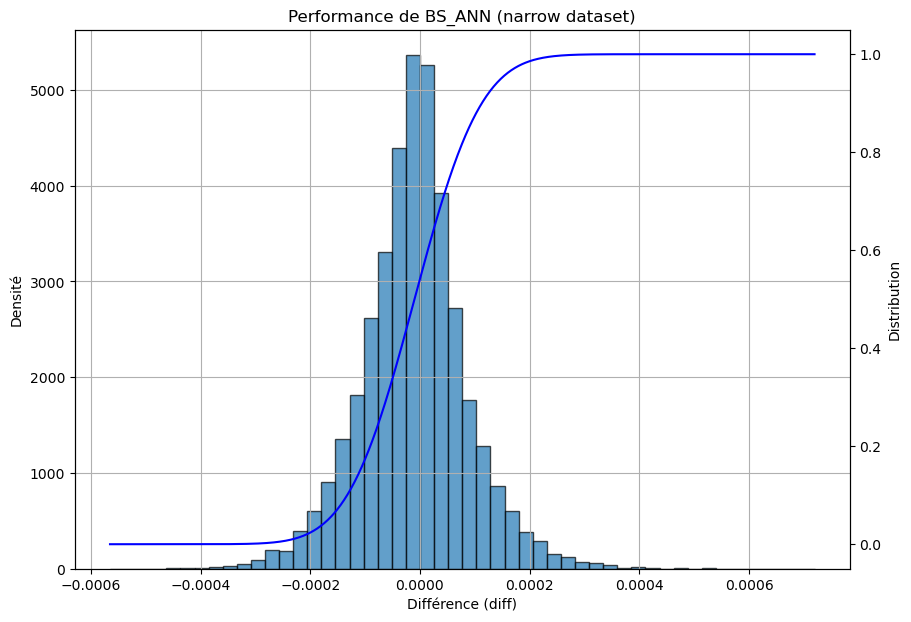

Erreur maximale : 0.0007195212
Erreur minimale : -0.00056511164
Moyenne des erreurs : -9.969062e-06
Écart-type des erreurs : 9.583524e-05


In [21]:
# Calcul des erreurs sur l'ensemble de test
erreurs = []
with torch.no_grad():
    for data in test_loader:
        inputs, targets = data[:, :-1].to(device), data[:, -1].to(device)
        outputs = loaded_BS_ANN(inputs)
        erreurs.append((targets - outputs).cpu().numpy())
    erreurs = np.concatenate(erreurs)

mean_error = erreurs.mean()  
std_error = erreurs.std()    

# Création des points pour la courbe de distribution cumulative (CDF)
x = np.linspace(erreurs.min(), erreurs.max(), 1000)
cdf = norm.cdf(x, loc=mean_error, scale=std_error)  

# Visualisation
fig, ax1 = plt.subplots(figsize=(10, 7))

# Histogramme des erreurs
ax1.hist(erreurs, bins=50, density=True, edgecolor='black', alpha=0.7, label="Histogramme des erreurs")
ax1.set_xlabel("Différence (diff)")
ax1.set_ylabel("Densité")
ax1.grid()
ax2 = ax1.twinx()
ax2.plot(x, cdf, 'b-')
ax2.set_ylabel("Distribution")
plt.title("Performance de BS_ANN (narrow dataset)")
plt.show()


print("Erreur maximale :", erreurs.max())
print("Erreur minimale :", erreurs.min())
print("Moyenne des erreurs :", mean_error)
print("Écart-type des erreurs :", std_error)

>### La graphique ci-dessus nous donne l'erreur absolue maximale qui est d'environ 0.07% (narrow dataset)
>### qui est un meilleur résultat.


In [22]:
# Fonction pour calculer les scores d'évaluation
def evaluate_model(loader, model, device):
    """
    Évalue le modèle sur un DataLoader donné (train ou test).
    Retourne les prédictions et les cibles réelles.
    """
    outputs = []
    targets = []
    with torch.no_grad():  
        for data in loader:
            inputs, target = data[:, :-1].to(device), data[:, -1].to(device)  
            output = model(inputs)  
            outputs.append(output.cpu().numpy())  
            targets.append(target.cpu().numpy())
    return np.concatenate(outputs), np.concatenate(targets)

# Évaluation sur l'ensemble d'entraînement
outputs_train, targets_train = evaluate_model(train_loader, loaded_BS_ANN, device)
print("Scores de training:")
print(f"MSE  : {mean_squared_error(outputs_train, targets_train):e}")
print(f"RMSE : {np.sqrt(mean_squared_error(outputs_train, targets_train)):e}")
print(f"MAE  : {mean_absolute_error(outputs_train, targets_train):e}")
print(f"MAPE : {mean_absolute_percentage_error(outputs_train, targets_train):e}")
print(f"R2   : {r2_score(outputs_train, targets_train):e}")
print("-------------------")

# Évaluation sur l'ensemble de test
outputs_test, targets_test = evaluate_model(test_loader, loaded_BS_ANN, device)
print("Scores de test:")
print(f"MSE  : {mean_squared_error(outputs_test, targets_test):e}")
print(f"RMSE : {np.sqrt(mean_squared_error(outputs_test, targets_test)):e}")
print(f"MAE  : {mean_absolute_error(outputs_test, targets_test):e}")
print(f"MAPE : {mean_absolute_percentage_error(outputs_test, targets_test):e}")
print(f"R2   : {r2_score(outputs_test, targets_test):e}")

Scores de training:
MSE  : 8.240802e-09
RMSE : 9.077886e-05
MAE  : 6.828186e-05
MAPE : 9.701423e-02
R2   : 9.999998e-01
-------------------
Scores de test:
MSE  : 9.283774e-09
RMSE : 9.635234e-05
MAE  : 7.160132e-05
MAPE : 8.819261e-02
R2   : 9.999997e-01


>### Nous avons démontré que l'utilisation d'un "narrow dataset"  pour entraîner le ANN donne des résultats légèrement meilleurs, comme mentionné dans l'article.
>
>

# 2) Réseau de volatilité implicite : IV_ANN

In [23]:
class IV_ANN(BS_ANN):
    """
    Cette classe hérite de la classe BS_ANN.   
    """
    pass 

### 1.Génération de données avec log-transformation

### Input:
$$
\left\{\log (\tilde{V} / K), S_{0} / K, r, \tau\right\}
$$

### où

$$
\tilde{V}=V_{t}-\max \left(S_{t}-K e^{-r \tau}, 0\right)
$$


In [24]:
def IV_LHS_data_generator(n=10**6, low_bounds=[0.5, 0.05, 0.0, 0.05], up_bounds=[1.4, 1, 0.1, 1], log_scale=True):
    """
    Génère des échantillons de prix d'options call en utilisant un échantillonnage Latin hypercube.
    Retourne un tenseur PyTorch de dimension (n, 5) contenant les échantillons d'entrées et la volatilité en tant que cible.
    Applique une transformation logarithmique de V/K si l'option log_scale est activée.

    Les entrées sont :
    - Moneyness (S/K)
    - Temps à maturité (tau)
    - Taux sans risque (r)
    - (log(V/K)).

    Paramètres :
    - n : nombre d'échantillons.
    - low_bounds : bornes inférieures pour les entrées.
    - up_bounds : bornes supérieures pour les entrées.
    - log_scale : applique une transformation logarithmique si True.

    Retourne :
    - Un tenseur PyTorch contenant les échantillons et les cibles.
    """
    sampler = qmc.LatinHypercube(d=4)
    sample = sampler.random(n)
    sample = qmc.scale(sample, low_bounds, up_bounds)

    # Calcul des prix d'options avec la fonction BS
    bs_prices = BS_moneyness_call(sample[:, 0], sample[:, 1], sample[:, 2], sample[:, 3]).reshape((-1, 1))

    # Construction du dataset
    bs_dataset = np.concatenate((sample[:, :-1], bs_prices, sample[:, 3].reshape((n, 1))), axis=1)

    # Transformation logarithmique si activée
    if log_scale:
        bs_dataset[:, 3] -= np.maximum(bs_dataset[:, 0] - np.exp(-bs_dataset[:, 1] * bs_dataset[:, 2]), 0)
        indices = np.argwhere(bs_dataset[:, 3] < 1e-7)
        bs_dataset = np.delete(bs_dataset, indices, 0)
        bs_dataset[:, 3] = np.log(bs_dataset[:, 3])

    # Affichage des bornes
    input_labels = ["S/K", "Tau", "r", "log(V/K)" if log_scale else "V/K"]
    output_label = "Sigma"

    print("------ INPUT ------")
    for i, label in enumerate(input_labels):
        print(f"{label:<12}: [{bs_dataset[:, i].min():.2f}, {bs_dataset[:, i].max():.2f}]")
    print("------ OUTPUT ------")
    print(f"{output_label:<12}: [{bs_dataset[:, -1].min():.2f}, {bs_dataset[:, -1].max():.2f}]")

    return torch.FloatTensor(bs_dataset)

# Test de la fonction
bs_dataset = IV_LHS_data_generator(log_scale=True)


------ INPUT ------
S/K         : [0.50, 1.40]
Tau         : [0.05, 1.00]
r           : [0.00, 0.10]
log(V/K)    : [-16.12, -0.98]
------ OUTPUT ------
Sigma       : [0.05, 1.00]


### 2.L'entrainement du IV_ANN avec log-transformation

In [25]:
# parametres
args = {
    "batch_size": 1024,
    "test_batch_size": 4048,
    "epochs": 3000,  
    "lr": 1e-4,
    "gamma": 0.1,  
    "run_dry": False,
    "log_interval": 100,
    "dry_run": False,
    "seed": 0,
    "no_cuda": False,
    "save_model": True,
}



use_cuda = not args["no_cuda"] and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
bs_dataset = IV_LHS_data_generator(n = 10**5, log_scale = True)
train_size, test_size = int(bs_dataset.shape[0]*0.9), int(bs_dataset.shape[0]*0.1 ) 
train_dataset, test_dataset = torch.utils.data.random_split(bs_dataset, [train_size, bs_dataset.shape[0]-train_size])
train_loader = torch.utils.data.DataLoader(train_dataset,args["batch_size"])
test_loader = torch.utils.data.DataLoader(test_dataset, args["test_batch_size"])

# Model training
print(device)
model = IV_ANN().to(device)
optimizer = optim.Adam(model.parameters(), lr=args["lr"])
scheduler = StepLR(optimizer, step_size=10**3, gamma=args["gamma"])

train_losses = []
test_losses = []
for epoch in range(1, args["epochs"] + 1):
  train_loss = model.train_model(args, device, train_loader, optimizer, epoch)
  test_loss = model.test_model(device, test_loader)
  print(f"Current Learning Rate: {scheduler.get_last_lr()[0]:.6e}")
  scheduler.step()
  train_losses.append(train_loss)
  test_losses.append(test_loss)
if args["save_model"] :
  torch.save(model.state_dict(), "IV_SCALED_ANN.pt")  

------ INPUT ------
S/K         : [0.50, 1.40]
Tau         : [0.05, 1.00]
r           : [0.00, 0.10]
log(V/K)    : [-16.11, -0.99]
------ OUTPUT ------
Sigma       : [0.05, 1.00]
cuda
Train Epoch: 1 [0/85043 (0%)]	log Loss: -1.218066

Train set: Average log loss: -3.1180


Test set: Average loss: -3.7779

Current Learning Rate: 1.000000e-04
Train Epoch: 2 [0/85043 (0%)]	log Loss: -3.820870

Train set: Average log loss: -3.9075


Test set: Average loss: -4.0724

Current Learning Rate: 1.000000e-04
Train Epoch: 3 [0/85043 (0%)]	log Loss: -4.162083

Train set: Average log loss: -4.3166


Test set: Average loss: -4.8155

Current Learning Rate: 1.000000e-04
Train Epoch: 4 [0/85043 (0%)]	log Loss: -4.931334

Train set: Average log loss: -5.3985


Test set: Average loss: -5.9438

Current Learning Rate: 1.000000e-04
Train Epoch: 5 [0/85043 (0%)]	log Loss: -6.043703

Train set: Average log loss: -6.2012


Test set: Average loss: -6.3862

Current Learning Rate: 1.000000e-04
Train Epoch: 6 [0/850

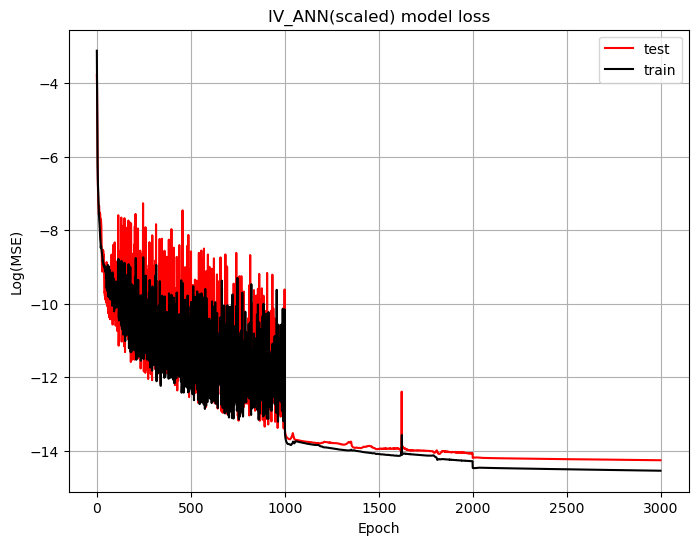

In [26]:
# Plot log(MSE) over epoch
plt.figure(figsize=(8,6))
plt.plot( np.log(test_losses), label = "test", color = 'red')
plt.plot( np.log(train_losses), label = "train", color = 'black')

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Log(MSE)")
plt.title("IV_ANN(scaled) model loss" )
plt.grid()

In [27]:
# Chargement du modèle IV_ANN
device = torch.device("cuda")
loaded_IV_ANN = IV_ANN().to(device)
PATH = r'C:\Users\qiyao\OneDrive\Desktop\Documents\Documents_M2\ProbaNum avancée\Projet-reproduce\IV_SCALED_ANN.pt'
loaded_IV_ANN.load_state_dict(torch.load(PATH))
loaded_IV_ANN.eval()

C:\Users\qiyao\AppData\Local\Temp\ipykernel_25744\963397500.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_IV_ANN.load_state_dict(torch.load(PATH))


IV_ANN(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=400, bias=True)
    (1-3): 3 x Linear(in_features=400, out_features=400, bias=True)
    (4): Linear(in_features=400, out_features=1, bias=True)
  )
)

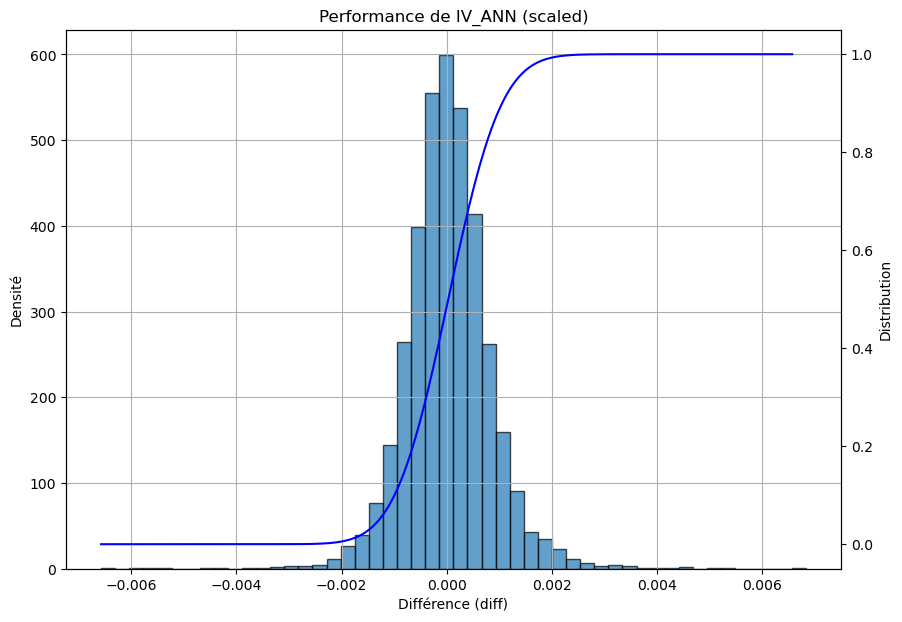

Erreur maximale : 0.006833732
Erreur minimale : -0.0065764785
Moyenne des erreurs : 3.0935735e-05
Écart-type des erreurs : 0.0007996647


In [28]:
# Calcul des erreurs sur l'ensemble de test
erreurs = []
with torch.no_grad():
    for data in test_loader:
        inputs, targets = data[:, :-1].to(device), data[:, -1].to(device)
        outputs = loaded_IV_ANN(inputs)
        erreurs.append((targets - outputs).cpu().numpy())
    erreurs = np.concatenate(erreurs)

mean_error = erreurs.mean()  
std_error = erreurs.std()    

# Création des points pour la courbe de distribution cumulative (CDF)
x = np.linspace(erreurs.min(), -erreurs.min(), 1000)
cdf = norm.cdf(x, loc=mean_error, scale=std_error)  

# Visualisation
fig, ax1 = plt.subplots(figsize=(10, 7))

# Histogramme des erreurs
ax1.hist(erreurs, bins=50, density=True, edgecolor='black', alpha=0.7, label="Histogramme des erreurs")
ax1.set_xlabel("Différence (diff)")
ax1.set_ylabel("Densité")
ax1.grid()
ax2 = ax1.twinx()
ax2.plot(x, cdf, 'b-')
ax2.set_ylabel("Distribution")
plt.title("Performance de IV_ANN (scaled)")
plt.show()


print("Erreur maximale :", erreurs.max())
print("Erreur minimale :", erreurs.min())
print("Moyenne des erreurs :", mean_error)
print("Écart-type des erreurs :", std_error)

In [29]:
# Évaluation sur l'ensemble d'entraînement
outputs_train, targets_train = evaluate_model(train_loader, loaded_IV_ANN, device)
print("Scores de training:")
print(f"MSE  : {mean_squared_error(outputs_train, targets_train):e}")
print(f"RMSE : {np.sqrt(mean_squared_error(outputs_train, targets_train)):e}")
print(f"MAE  : {mean_absolute_error(outputs_train, targets_train):e}")
print(f"MAPE : {mean_absolute_percentage_error(outputs_train, targets_train):e}")
print(f"R2   : {r2_score(outputs_train, targets_train):e}")
print("-------------------")

# Évaluation sur l'ensemble de test
outputs_test, targets_test = evaluate_model(test_loader, loaded_IV_ANN, device)
print("Scores de test:")
print(f"MSE  : {mean_squared_error(outputs_test, targets_test):e}")
print(f"RMSE : {np.sqrt(mean_squared_error(outputs_test, targets_test)):e}")
print(f"MAE  : {mean_absolute_error(outputs_test, targets_test):e}")
print(f"MAPE : {mean_absolute_percentage_error(outputs_test, targets_test):e}")
print(f"R2   : {r2_score(outputs_test, targets_test):e}")

Scores de training:
MSE  : 4.712536e-07
RMSE : 6.864791e-04
MAE  : 5.193916e-04
MAPE : 1.366305e-03
R2   : 9.999932e-01
-------------------
Scores de test:
MSE  : 6.404207e-07
RMSE : 8.002629e-04
MAE  : 5.869559e-04
MAPE : 1.563380e-03
R2   : 9.999908e-01


### 2.L'entrainement du IV_ANN sans log-transformation

In [30]:
# Parametres
args = {
    "batch_size": 1024,
    "test_batch_size": 4048,
    "epochs": 3000,  
    "lr": 1e-4,
    "gamma": 0.1,  
    "run_dry": False,
    "log_interval": 100,
    "dry_run": False,
    "seed": 0,
    "no_cuda": False,
    "save_model": True,
}



use_cuda = not args["no_cuda"] and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


bs_dataset = IV_LHS_data_generator(n = 10**5, log_scale = False) # log_scale = False
train_size, test_size = int(bs_dataset.shape[0]*0.9), int(bs_dataset.shape[0]*0.1 ) 
train_dataset, test_dataset = torch.utils.data.random_split(bs_dataset, [train_size, bs_dataset.shape[0]-train_size])


train_loader = torch.utils.data.DataLoader(train_dataset,args["batch_size"])
test_loader = torch.utils.data.DataLoader(test_dataset, args["test_batch_size"])


print(device)
model = IV_ANN().to(device)
optimizer = optim.Adam(model.parameters(), lr=args["lr"]) 
scheduler = StepLR(optimizer, step_size=10**3, gamma=args["gamma"]) 

train_losses = []
test_losses = []
for epoch in range(1, args["epochs"] + 1):
  train_loss = model.train_model(args, device, train_loader, optimizer, epoch)
  test_loss = model.test_model(device, test_loader)
  print(f"Current Learning Rate: {scheduler.get_last_lr()[0]:.6e}")
  scheduler.step()
  train_losses.append(train_loss)
  test_losses.append(test_loss)
if args["save_model"] :
  torch.save(model.state_dict(), "IV_UNSCALED_ANN.pt")
    

------ INPUT ------
S/K         : [0.50, 1.40]
Tau         : [0.05, 1.00]
r           : [0.00, 0.10]
V/K         : [0.00, 0.69]
------ OUTPUT ------
Sigma       : [0.05, 1.00]
cuda
Train Epoch: 1 [0/90000 (0%)]	log Loss: -0.978695

Train set: Average log loss: -2.4659


Test set: Average loss: -2.6201

Current Learning Rate: 1.000000e-04
Train Epoch: 2 [0/90000 (0%)]	log Loss: -2.648452

Train set: Average log loss: -2.7213


Test set: Average loss: -2.8724

Current Learning Rate: 1.000000e-04
Train Epoch: 3 [0/90000 (0%)]	log Loss: -2.907224

Train set: Average log loss: -3.1848


Test set: Average loss: -3.5083

Current Learning Rate: 1.000000e-04
Train Epoch: 4 [0/90000 (0%)]	log Loss: -3.536057

Train set: Average log loss: -3.7167


Test set: Average loss: -3.9386

Current Learning Rate: 1.000000e-04
Train Epoch: 5 [0/90000 (0%)]	log Loss: -3.969140

Train set: Average log loss: -4.0960


Test set: Average loss: -4.2118

Current Learning Rate: 1.000000e-04
Train Epoch: 6 [0/90000 

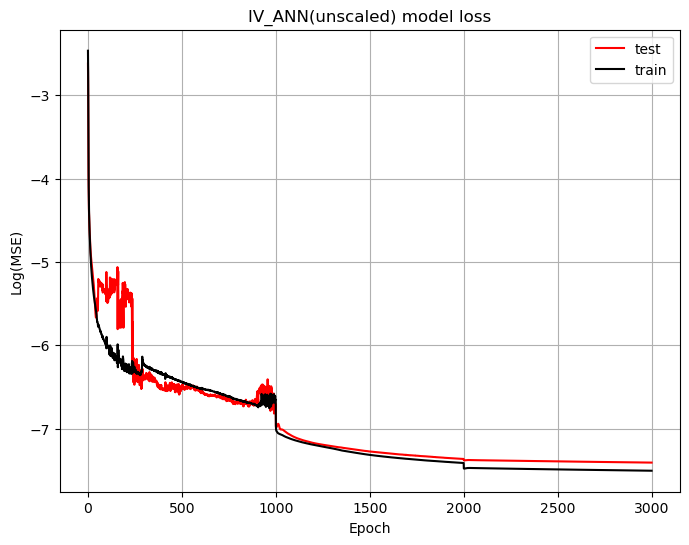

In [31]:
# Plot log(MSE) over epoch
plt.figure(figsize=(8,6))
plt.plot( np.log(test_losses), label = "test", color = 'red')
plt.plot( np.log(train_losses), label = "train", color = 'black')

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Log(MSE)")
plt.title("IV_ANN(unscaled) model loss" )
plt.grid()

In [32]:
# Chargement du modèle IV_ANN
device = torch.device("cuda")
loaded_IV_ANN = IV_ANN().to(device)
PATH = r'C:\Users\qiyao\OneDrive\Desktop\Documents\Documents_M2\ProbaNum avancée\Projet-reproduce\IV_UNSCALED_ANN.pt'
loaded_IV_ANN.load_state_dict(torch.load(PATH))
loaded_IV_ANN.eval()

C:\Users\qiyao\AppData\Local\Temp\ipykernel_25744\1637873670.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_IV_ANN.load_state_dict(torch.load(PATH))


IV_ANN(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=400, bias=True)
    (1-3): 3 x Linear(in_features=400, out_features=400, bias=True)
    (4): Linear(in_features=400, out_features=1, bias=True)
  )
)

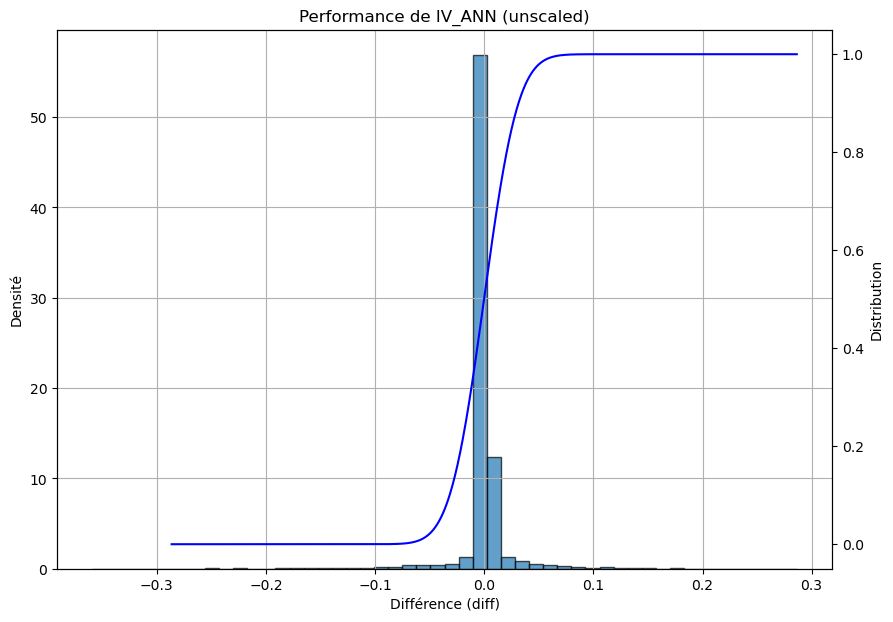

Erreur maximale : 0.2863729
Erreur minimale : -0.3590865
Moyenne des erreurs : -0.0001777332
Écart-type des erreurs : 0.024618074


In [33]:
# Calcul des erreurs sur l'ensemble de test
erreurs = []
with torch.no_grad():
    for data in test_loader:
        inputs, targets = data[:, :-1].to(device), data[:, -1].to(device)
        outputs = loaded_IV_ANN(inputs)
        erreurs.append((targets - outputs).cpu().numpy())
    erreurs = np.concatenate(erreurs)

mean_error = erreurs.mean()  
std_error = erreurs.std()   

# Création des points pour la courbe de distribution cumulative (CDF)
x = np.linspace(-erreurs.max(), erreurs.max(), 1000)
cdf = norm.cdf(x, loc=mean_error, scale=std_error)  

# Visualisation
fig, ax1 = plt.subplots(figsize=(10, 7))

# Histogramme des erreurs
ax1.hist(erreurs, bins=50, density=True, edgecolor='black', alpha=0.7, label="Histogramme des erreurs")
ax1.set_xlabel("Différence (diff)")
ax1.set_ylabel("Densité")
ax1.grid()
ax2 = ax1.twinx()
ax2.plot(x, cdf, 'b-')
ax2.set_ylabel("Distribution")
plt.title("Performance de IV_ANN (unscaled)")
plt.show()


print("Erreur maximale :", erreurs.max())
print("Erreur minimale :", erreurs.min())
print("Moyenne des erreurs :", mean_error)
print("Écart-type des erreurs :", std_error)

In [34]:
# Évaluation sur l'ensemble d'entraînement
outputs_train, targets_train = evaluate_model(train_loader, loaded_IV_ANN, device)
print("Scores de training:")
print(f"MSE  : {mean_squared_error(outputs_train, targets_train):e}")
print(f"RMSE : {np.sqrt(mean_squared_error(outputs_train, targets_train)):e}")
print(f"MAE  : {mean_absolute_error(outputs_train, targets_train):e}")
print(f"MAPE : {mean_absolute_percentage_error(outputs_train, targets_train):e}")
print(f"R2   : {r2_score(outputs_train, targets_train):e}")
print("-------------------")

# Évaluation sur l'ensemble de test
outputs_test, targets_test = evaluate_model(test_loader, loaded_IV_ANN, device)
print("Scores de test:")
print(f"MSE  : {mean_squared_error(outputs_test, targets_test):e}")
print(f"RMSE : {np.sqrt(mean_squared_error(outputs_test, targets_test)):e}")
print(f"MAE  : {mean_absolute_error(outputs_test, targets_test):e}")
print(f"MAPE : {mean_absolute_percentage_error(outputs_test, targets_test):e}")
print(f"R2   : {r2_score(outputs_test, targets_test):e}")

Scores de training:
MSE  : 5.390606e-04
RMSE : 2.321768e-02
MAE  : 7.719943e-03
MAPE : 3.766585e-02
R2   : 9.927708e-01
-------------------
Scores de test:
MSE  : 6.060812e-04
RMSE : 2.461872e-02
MAE  : 8.026186e-03
MAPE : 3.869338e-02
R2   : 9.919511e-01


>### On peut conclure que l'utilisation de la transformation logarithmique (*log-transformation*) pour ajuster les gradients peut améliorer de manière significative la précision des prédictions.
>

# 3) Méthode de Brent

### 1.Nous préparons l'algorithme de la méthode de Brent afin de comparer l'efficacité du calcul de la volatilité implicite par des méthodes numériques avec celle obtenue à l'aide du IV_ANN.

In [35]:
# La méthode de Brent
def calcimpliedvol(row):
    moneyness, T, r, market_option_price = row
    
    def bs_price(sigma):
        d1 = (np.log(moneyness) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        model_price = moneyness * norm.cdf(d1) - np.exp(-r * T) * norm.cdf(d2)
        return model_price - market_option_price

    try:
        return optimize.brentq(bs_price, 1e-6, 5, maxiter=100)
    except ValueError:
        return np.nan

In [36]:
# Chargement du IV_ANN 
loaded_IV_ANN = IV_ANN().to("cuda" if torch.cuda.is_available() else "cpu")
loaded_IV_ANN.load_state_dict(torch.load("IV_SCALED_ANN.pt"))
loaded_IV_ANN.eval()

C:\Users\qiyao\AppData\Local\Temp\ipykernel_25744\1261341666.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_IV_ANN.load_state_dict(torch.load("IV_SCALED_ANN.pt")

IV_ANN(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=400, bias=True)
    (1-3): 3 x Linear(in_features=400, out_features=400, bias=True)
    (4): Linear(in_features=400, out_features=1, bias=True)
  )
)

### 2.Comparaison de la méthode de brent et la méthode de IV_ANN

In [37]:
# Genetation des donnees
bs_dataset = IV_LHS_data_generator(n=10**6).data
ground_truth_vol = bs_dataset[:, 4]
inputs = torch.FloatTensor(bs_dataset[:, [0, 1, 2, 3]])

# Comparer le temps de calcul des Brent et IV_ANN
def measure_time(method, inputs, device="cpu"):
    
    start_time = time.time()
    
    if method == "Brent":
        inputs_np = inputs.cpu().numpy()  
        result = np.apply_along_axis(calcimpliedvol, 1, inputs_np)
    elif method == "IV_ANN":
        loaded_IV_ANN.to(device)
        inputs = inputs.to(device)
        with torch.no_grad():
            
            result = loaded_IV_ANN(inputs).cpu().numpy()
    
    end_time = time.time()
    return result, end_time - start_time

# Temps--CPU
print("Measuring on CPU...")
inputs_cpu = inputs.cpu()
brent_vol_cpu, brent_time_cpu = measure_time("Brent", inputs_cpu, device="cpu")
iv_ann_vol_cpu, iv_ann_time_cpu = measure_time("IV_ANN", inputs_cpu, device="cpu")

# Temps--GPU
if torch.cuda.is_available():
    print("Measuring on GPU...")
    inputs_gpu = inputs.cuda()
    _, brent_time_gpu = measure_time("Brent", inputs_gpu, device="cuda")  
    _, iv_ann_time_gpu = measure_time("IV_ANN", inputs_gpu, device="cuda")
else:
    brent_time_gpu = None
    iv_ann_time_gpu = None

------ INPUT ------
S/K         : [0.50, 1.40]
Tau         : [0.05, 1.00]
r           : [0.00, 0.10]
log(V/K)    : [-16.12, -0.98]
------ OUTPUT ------
Sigma       : [0.05, 1.00]
Measuring on CPU...
Measuring on GPU...


In [38]:
print(f"Time on CPU (Brent): {brent_time_cpu:.4f} seconds")
print(f"Time on CPU (IV_ANN): {iv_ann_time_cpu:.4f} seconds")
print(f"Time on GPU (Brent): {brent_time_gpu:.4f} seconds")
print(f"Time on GPU (IV_ANN): {iv_ann_time_gpu:.4f} seconds")

Time on CPU (Brent): 131.9654 seconds
Time on CPU (IV_ANN): 1.7676 seconds
Time on GPU (Brent): 129.8410 seconds
Time on GPU (IV_ANN): 0.4521 seconds


# 4) Réseau de valorisation Heston : Heston-ANN

### 1.Méthode de Monte Carlo pour calculer le prix de Heston model.

In [39]:
def heston_monte_carlo(moneyness, r, tau, kappa, theta, gamma, v0, rho, M, N, device='cuda'):
    """
    Simulation Monte Carlo pour le modèle Heston avec prise en charge des batchs.
    """
    # Calcul de S0 et K
    K = torch.tensor(1.0, device=device)  # Prix d'exercice normalisé
    S0 = torch.tensor(moneyness, device=device) * K
    
    # Initialisation des paramètres
    dt = torch.tensor(tau / N, device=device)
    r, v0, kappa, theta, gamma, rho = map(
        lambda x: torch.tensor(x, device=device), (r, v0, kappa, theta, gamma, rho)
    )

    # Initialisation des chemins, M trajectoires, N pas de discret
    S = torch.zeros((M, N + 1), device=device)
    v = torch.zeros((M, N + 1), device=device)
    S[:, 0] = S0
    v[:, 0] = v0

    
    Z1 = torch.randn(M, N, device=device)
    Z2 = torch.randn(M, N, device=device)
    W1 = Z1
    W2 = rho * Z1 + torch.sqrt(1 - rho**2) * Z2

    # Simulation des chemins
    for t in range(1, N + 1):
        v[:, t] = v[:, t - 1] + kappa * (theta - v[:, t - 1]) * dt + \
                  gamma * torch.sqrt(torch.clamp(v[:, t - 1], min=0)) * torch.sqrt(dt) * W2[:, t - 1]
        v[:, t] = torch.clamp(v[:, t], min=0)
        S[:, t] = S[:, t - 1] * torch.exp((r - 0.5 * v[:, t - 1]) * dt + \
                  torch.sqrt(torch.clamp(v[:, t - 1], min=0)) * torch.sqrt(dt) * W1[:, t - 1])

    
    payoff = torch.clamp(S[:, -1] - K, min=0)

    
    option_price = torch.exp(-r * tau) * torch.mean(payoff)
    return option_price.item()

In [40]:
def monte_carlo_stats(sample, confidence=0.95):
    """
    Monte Carlo générale.
    """
    mean = np.mean(sample)
    var = np.var(sample, ddof=1)  
    std_err = np.sqrt(var / len(sample))  
    z = norm.ppf((1 + confidence) / 2)  
    ci_lower = mean - z * std_err  
    ci_upper = mean + z * std_err  

    return mean, var, ci_lower, ci_upper

In [41]:
def test_convergence(moneyness, r, tau, kappa, theta, gamma, v0, rho, N, M_values, device='cuda'):
    """
    Les résultats de  Méthode de Monte Carlo appliqué au Heston
    """
    results = []
    
    for M in M_values:
        payoffs = []
        for _ in range(10):
            price = heston_monte_carlo(moneyness, r, tau, kappa, theta, gamma, v0, rho, M, N, device)
            payoffs.append(price)
        
        mean, var, ci_lower, ci_upper = monte_carlo_stats(payoffs, confidence=0.95)
        results.append({
            "Trajectoires (M)": M,
            "Prix estimé (mean)": mean,
            "Variance": var,
            "CI inférieure": ci_lower,
            "CI supérieure": ci_upper,
        })
        
        #print(f"Trajectoires : {M}, Mean: {mean:.6f}, Variance: {var:.6e}, CI: [{ci_lower:.6f}, {ci_upper:.6f}]")
    
    df_results = pd.DataFrame(results)
    return df_results

moneyness = 1.2       
r = 0.03       
tau = 1        
kappa = 2.0    
theta = 0.04   
gamma = 0.2    
v0 = 0.04      
rho = -0.7     
N = 50       

M_values = [10**2, 10**3, 10**4, 10**5, 10**6]  

df_results = test_convergence(moneyness, r, tau, kappa, theta, gamma, v0, rho, N, M_values, device='cuda')

df_results

Trajectoires (M)  Prix estimé (mean)      Variance  CI inférieure  \
0               100            0.263399  1.031622e-04       0.257104   
1              1000            0.250541  4.040018e-05       0.246601   
2             10000            0.249881  3.415849e-06       0.248736   
3            100000            0.249806  6.007312e-07       0.249325   
4           1000000            0.249592  3.325770e-08       0.249479   

   CI supérieure  
0       0.269695  
1       0.254480  
2       0.251027  
3       0.250286  
4       0.249705

>### Dans la suite on prend M = 10000.
>
>

### 2.Généralisation des données

###   Modèle de Heston:
$$
dS_t = r S_t dt + \sqrt{v_t} S_t dW_t^S, \quad S_0 = S_0, \\
dv_t = \kappa (\theta - v_t) dt + \gamma \sqrt{v_t} dW_t^v, \quad v_0 = v_0, \\
dW_t^S dW_t^v = \rho dt,
$$

### input:

$$
\left\{\rho, \theta, \gamma, v_0, \kappa, S_{0} / K, r, \tau\right\}
$$



In [42]:
eps = 1e-2  # Utilisé pour générer des intervalles ouverts

def Heston_LHS_data_generator(
    n=10**6,
    low_bounds=[0.6+eps, 0.1+eps, 0.0+eps, -0.95+eps, 0.4+eps, 0.0+eps, 0.0+eps, 0.05+eps],
    up_bounds=[1.4-eps, 1.4-eps, 0.1-eps, 0.0-eps, 2.0-eps, 0.5-eps, 0.5-eps, 0.5-eps]
):
    """
    Génère des échantillons de prix d'options call avec le modèle de Heston en utilisant
    l'échantillonnage en hypercube latin (LHS).

    Paramètres :
    - n : nombre d'échantillons à générer
    - low_bounds : bornes inférieures pour les entrées
    - up_bounds : bornes supérieures pour les entrées

    Retourne :
    - torch.FloatTensor contenant les échantillons générés et leurs prix
    """
    # Génération des échantillons avec LHS
    sample_ = qmc.LatinHypercube(d=8)  # 8 dimensions pour les entrées
    sample = sample_.random(n)
    sample = qmc.scale(sample, low_bounds, up_bounds)

    # Filtrage des échantillons selon les contraintes
    indecies = np.argwhere(2 * sample[:, 4] * sample[:, 5] <= sample[:, 6] ** 2)
    sample = np.delete(sample, indecies, 0)

    # Calcul des prix avec le modèle de Heston
    hs_prices = []
    for i in range(sample.shape[0]):  # Traiter les échantillons un par un
        hs_price = heston_monte_carlo(
            M=10000,
            N=50,
            moneyness=sample[i, 0],  # Un seul échantillon pour chaque appel
            r=sample[i, 2],
            tau=sample[i, 1],
            kappa=sample[i, 4],
            theta=sample[i, 5],
            gamma=sample[i, 6],
            v0=sample[i, 7],
            rho=sample[i, 3]
        )
        hs_prices.append(hs_price)
    hs_prices = np.array(hs_prices).reshape((-1, 1))

    # Création du dataset complet
    hs_dataset = np.concatenate((sample, hs_prices), axis=1)

    # Impression des plages de données
    print("------ INPUT ------")
    for i, name in enumerate(["S/K", "Tau", "r", "rho", "Kappa", "theta", "Gamma", "V_0"]):
        print(f"{name}.......... [{hs_dataset[:, i].min():.2f} {hs_dataset[:, i].max():.2f}]")
    print("------ OUTPUT ------")
    print(f"V/K.......... [{hs_dataset[:, -1].min():.2f} {hs_dataset[:, -1].max():.2f}]")

    return torch.FloatTensor(hs_dataset)

# Génération de données avec 100 000 échantillons
hs_dataset = Heston_LHS_data_generator(10**5)


------ INPUT ------
S/K.......... [0.61 1.39]
Tau.......... [0.11 1.39]
r.......... [0.01 0.09]
rho.......... [-0.94 -0.01]
Kappa.......... [0.41 1.99]
theta.......... [0.01 0.49]
Gamma.......... [0.01 0.49]
V_0.......... [0.06 0.49]
------ OUTPUT ------
V/K.......... [0.00 0.65]


In [43]:
class Heston_ANN(nn.Module):
    def __init__(self):
        """
        Initialise le réseau Heston-ANN avec 4 couches cachées, 400 neurons par couche.
        Les poids sont initialisés avec Glorot_uniform (Xavier_uniform).
        Ce modèle prend en entrée 8 caractéristiques spécifiques au modèle de Heston.
        """
        super(Heston_ANN, self).__init__()
        # Définir les couches avec 8 entrées
        self.layers = nn.ModuleList([
            nn.Linear(8, 400),  # Couche d'entrée avec 8 caractéristiques
            nn.Linear(400, 400),
            nn.Linear(400, 400),
            nn.Linear(400, 400),
            nn.Linear(400, 1)  # Couche de sortie avec une seule sortie (prix de l'option)
        ])
        self._initialize_weights()
    
    # Le reste est identique à BS_ANN (IV_ANN)
    def _initialize_weights(self):
        """
        Initialise les poids de toutes les couches en utilisant Xavier_uniform.
        """
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                torch.nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        """
        Passage avant (forward pass) du réseau.
        Utilise l'activation ReLU, sauf pour la couche finale.
        """
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        return self.layers[-1](x).flatten()

    def _log_training(self, epoch, batch_idx, train_loader, loss, args):
        """
        Affiche les informations de journalisation pendant l'entraînement.
        """
        print(f'Train Epoch: {epoch} [{batch_idx * len(train_loader.dataset) // len(train_loader)}/'
              f'{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\t'
              f'log Loss: {np.log(loss):.6f}')

    def train_model(self, args, device, train_loader, optimizer, epoch):
        """
        Entraîne le modèle pour une époque.
        Retourne la perte moyenne de l'ensemble d'entraînement.
        """
        self.train()
        train_loss = 0

        for batch_idx, data in enumerate(train_loader):
            inputs, targets = data[:, :-1].to(device), data[:, -1].to(device)
            optimizer.zero_grad()
            output = self(inputs)
            loss = F.mse_loss(output, targets)
            train_loss += loss.item() * inputs.size(0)
            loss.backward()
            optimizer.step()

            if batch_idx % args["log_interval"] == 0:
                self._log_training(epoch, batch_idx, train_loader, loss.item(), args)
                if args["dry_run"]:
                    break

        train_loss /= len(train_loader.dataset)
        print(f'\nTrain set: Average log loss: {np.log(train_loss):.4f}\n')
        return train_loss

    def test_model(self, device, test_loader):
        """
        Teste le modèle sur un ensemble de données de test.
        Retourne la perte moyenne.
        """
        self.eval()
        test_loss = 0

        with torch.no_grad():
            for data in test_loader:
                inputs, targets = data[:, :-1].to(device), data[:, -1].to(device)
                output = self(inputs)
                test_loss += F.mse_loss(output, targets, reduction='sum').item()

        test_loss /= len(test_loader.dataset)
        print(f'\nTest set: Average loss: {np.log(test_loss):.4f}\n')
        return test_loss


In [44]:
# Paramètres d'entraînement
args = {
    "batch_size": 1024,
    "test_batch_size": 4048,
    "epochs": 3000,  
    "lr": 1e-4,
    "gamma": 0.1,  
    "run_dry": False,
    "log_interval": 100,
    "dry_run": False,
    "seed": 0,
    "no_cuda": False,
    "save_model": True,
}

# Configuration du périphérique (GPU ou CPU)
use_cuda = not args["no_cuda"] and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Chargement des données d'entraînement et de test

train_size = int(hs_dataset.shape[0] * 0.9)  # 90% pour l'entraînement
test_size = hs_dataset.shape[0] - train_size  # 10% pour le test

train_dataset, test_dataset = torch.utils.data.random_split(hs_dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args["batch_size"], shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args["test_batch_size"], shuffle=False)

# Initialisation du modèle, de l'optimiseur et du scheduler
print(device)
model = Heston_ANN().to(device)
optimizer = optim.Adam(model.parameters(), lr=args["lr"])  # Optimiseur Adam
scheduler = StepLR(optimizer, step_size=1000, gamma=args["gamma"])  # Réduction du LR tous les 1000 époques

train_losses = []
test_losses = []

# Boucle d'entraînement
for epoch in range(1, args["epochs"] + 1):
    train_loss = model.train_model(args, device, train_loader, optimizer, epoch)
    test_loss = model.test_model(device, test_loader)
    
    # Affichage du taux d'apprentissage actuel
    print(f"Current Learning Rate: {scheduler.get_last_lr()[0]:.6e}")
    scheduler.step()
    
    # Enregistrement des pertes
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Sauvegarde du modèle entraîné
if args["save_model"]:
    torch.save(model.state_dict(), "Heston_ANN.pt")


cuda
Train Epoch: 1 [0/83933 (0%)]	log Loss: -2.767039

Train set: Average log loss: -4.9474


Test set: Average loss: -7.4975

Current Learning Rate: 1.000000e-04
Train Epoch: 2 [0/83933 (0%)]	log Loss: -7.547931

Train set: Average log loss: -8.1245


Test set: Average loss: -8.7861

Current Learning Rate: 1.000000e-04
Train Epoch: 3 [0/83933 (0%)]	log Loss: -8.744431

Train set: Average log loss: -9.1018


Test set: Average loss: -9.4389

Current Learning Rate: 1.000000e-04
Train Epoch: 4 [0/83933 (0%)]	log Loss: -9.435263

Train set: Average log loss: -9.5900


Test set: Average loss: -9.7697

Current Learning Rate: 1.000000e-04
Train Epoch: 5 [0/83933 (0%)]	log Loss: -9.718427

Train set: Average log loss: -9.8809


Test set: Average loss: -10.0058

Current Learning Rate: 1.000000e-04
Train Epoch: 6 [0/83933 (0%)]	log Loss: -10.081852

Train set: Average log loss: -10.0634


Test set: Average loss: -10.0994

Current Learning Rate: 1.000000e-04
Train Epoch: 7 [0/83933 (0%)]	log Los

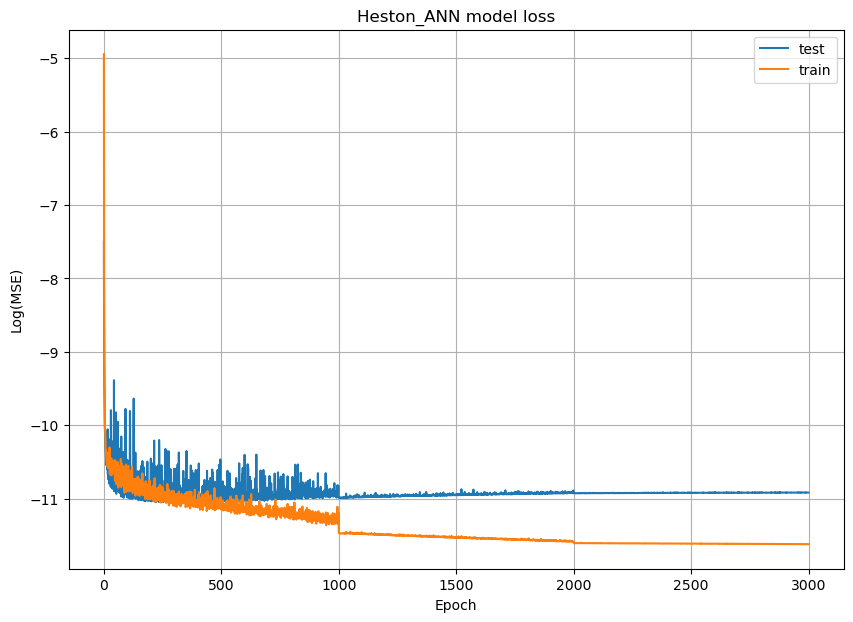

In [45]:
# Plotting log(MSE) as a function of epochs
plt.figure(figsize=(10,7))
plt.plot( np.log(test_losses), label = "test")
plt.plot( np.log(train_losses), label = "train")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Log(MSE)")
plt.title("Heston_ANN model loss" )
plt.grid()

In [46]:
# Chargement du modèle
device = 'cuda'
loaded_Heston_ANN = Heston_ANN().to(device)
PATH = r'C:\Users\qiyao\OneDrive\Desktop\Documents\Documents_M2\ProbaNum avancée\Projet-reproduce\Heston_ANN.pt'
loaded_Heston_ANN.load_state_dict(torch.load(PATH))
loaded_Heston_ANN.eval()

C:\Users\qiyao\AppData\Local\Temp\ipykernel_25744\1652214256.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_Heston_ANN.load_state_dict(torch.load(PATH))


Heston_ANN(
  (layers): ModuleList(
    (0): Linear(in_features=8, out_features=400, bias=True)
    (1-3): 3 x Linear(in_features=400, out_features=400, bias=True)
    (4): Linear(in_features=400, out_features=1, bias=True)
  )
)

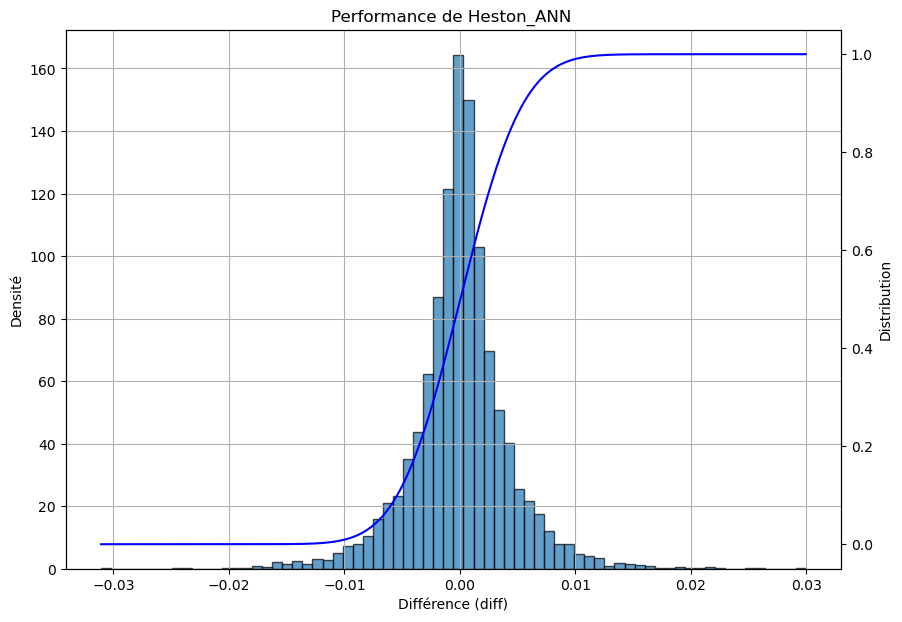

Erreur maximale : 0.02992928
Erreur minimale : -0.031057477
Moyenne des erreurs : 3.2414526e-05
Écart-type des erreurs : 0.00426245


In [47]:
# Calcul des erreurs sur l'ensemble de test
erreurs = []
with torch.no_grad():
    for data in test_loader:
        inputs, targets = data[:, :-1].to(device), data[:, -1].to(device)
        outputs = loaded_Heston_ANN(inputs)
        erreurs.append((targets - outputs).cpu().numpy())
    erreurs = np.concatenate(erreurs)

mean_error = erreurs.mean()  
std_error = erreurs.std()   

# Création des points pour la courbe de distribution cumulative (CDF)
x = np.linspace(erreurs.min(), erreurs.max(), 1000)
cdf = norm.cdf(x, loc=mean_error, scale=std_error)  

# Visualisation
fig, ax1 = plt.subplots(figsize=(10, 7))

# Histogramme des erreurs
ax1.hist(erreurs, bins=70, density=True, edgecolor='black', alpha=0.7, label="Histogramme des erreurs")
ax1.set_xlabel("Différence (diff)")
ax1.set_ylabel("Densité")
ax1.grid()
ax2 = ax1.twinx()
ax2.plot(x, cdf, 'b-')
ax2.set_ylabel("Distribution")
plt.title("Performance de Heston_ANN ")
plt.show()


print("Erreur maximale :", erreurs.max())
print("Erreur minimale :", erreurs.min())
print("Moyenne des erreurs :", mean_error)
print("Écart-type des erreurs :", std_error)

In [48]:
# Évaluation sur l'ensemble d'entraînement
outputs_train, targets_train = evaluate_model(train_loader, loaded_Heston_ANN, device)
print("Scores de training:")
print(f"MSE  : {mean_squared_error(outputs_train, targets_train):e}")
print(f"RMSE : {np.sqrt(mean_squared_error(outputs_train, targets_train)):e}")
print(f"MAE  : {mean_absolute_error(outputs_train, targets_train):e}")
print(f"MAPE : {mean_absolute_percentage_error(outputs_train, targets_train):e}")
print(f"R2   : {r2_score(outputs_train, targets_train):e}")
print("-------------------")

# Évaluation sur l'ensemble de test
outputs_test, targets_test = evaluate_model(test_loader, loaded_Heston_ANN, device)
print("Scores de testing:")
print(f"MSE  : {mean_squared_error(outputs_test, targets_test):e}")
print(f"RMSE : {np.sqrt(mean_squared_error(outputs_test, targets_test)):e}")
print(f"MAE  : {mean_absolute_error(outputs_test, targets_test):e}")
print(f"MAPE : {mean_absolute_percentage_error(outputs_test, targets_test):e}")
print(f"R2   : {r2_score(outputs_test, targets_test):e}")

Scores de training:
MSE  : 8.981920e-06
RMSE : 2.996985e-03
MAE  : 2.115840e-03
MAPE : 4.052826e-02
R2   : 9.995891e-01
-------------------
Scores de testing:
MSE  : 1.816953e-05
RMSE : 4.262574e-03
MAE  : 2.921894e-03
MAPE : 4.031585e-02
R2   : 9.991755e-01


# 5) Méthode 1, MonteCarlo + Brent = volatilité implicite 
## (Méthode numérique)

In [49]:
hs_dataset_data = hs_dataset.data
hs_dataset_data = hs_dataset_data[:,np.array([0,1,2,8])]
implied_vol_1 = np.apply_along_axis(calcimpliedvol, 1, hs_dataset_data)

# 6) Méthode 2, Heston_ANN + IV_ANN = volatilité implicite

In [50]:
# chargement du modèle
device = torch.device("cuda")
loaded_Heston_ANN = Heston_ANN().to(device)
PATH = r'C:\Users\qiyao\OneDrive\Desktop\Documents\Documents_M2\ProbaNum avancée\Projet-reproduce\Heston_ANN.pt'
loaded_Heston_ANN.load_state_dict(torch.load(PATH))
loaded_Heston_ANN.eval()

# chargement du donnée 
loader = torch.utils.data.DataLoader(hs_dataset, 4048)
# Prix
prices = []
with torch.no_grad():
  for data in loader:
    data, _ = data[:,:-1].to(device), data[:,-1].to(device)
    output = loaded_Heston_ANN(data)
    prices.append((output).data.cpu().numpy())
  prices = np.concatenate(prices)

# chargement du modèle 
device = torch.device("cuda")
loaded_IV_ANN = IV_ANN().to(device)
PATH = r'C:\Users\qiyao\OneDrive\Desktop\Documents\Documents_M2\ProbaNum avancée\Projet-reproduce\IV_SCALED_ANN.pt'
loaded_IV_ANN.load_state_dict(torch.load(PATH))
loaded_IV_ANN.eval()


# Considérer le prix obtenu par Heston_ANN comme un parametre du 'input' du IV_ANN 
hs_dataset2 = hs_dataset.data[:,np.array([0,1,2,8])]
hs_dataset2.data[:,3] = torch.FloatTensor(prices)
loader2 = torch.utils.data.DataLoader(hs_dataset2, 4048)

# Computing IVs
implied_vol = []
indecies_list = []
with torch.no_grad():
  for idx, data in enumerate(loader2):
    data = data.to(device)
    # LOG Transformation
    data[:,3] = data[:,3] - torch.maximum(data[:,0]-torch.exp(-data[:,1]*data[:,2]),torch.zeros(data[:,0].shape).to(device))
    data[:,3] = torch.log(data[:,3])
    output = loaded_IV_ANN(data)
    implied_vol.append((output).data.cpu().numpy())
  implied_vol_2 = np.concatenate(implied_vol)
  # indecies_list = np.concatenate(indecies_list).flatten()


C:\Users\qiyao\AppData\Local\Temp\ipykernel_25744\1192612340.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_Heston_ANN.load_state_dict(torch.load(PATH))
C:\Users

In [51]:
# Élimination des valeurs NaN résultant de prix inférieurs à 1e-7.
indecies = np.argwhere(np.isnan(implied_vol_2))
implied_vol_pipe1 = np.delete(implied_vol_1, indecies,0)
implied_vol_pipe2 = np.delete(implied_vol_2, indecies,0)

In [52]:
outputs = implied_vol_2
targets = implied_vol_1
print("Any NaN in outputs:", np.isnan(outputs).any())
print("Any NaN in targets:", np.isnan(targets).any())


Any NaN in outputs: True
Any NaN in targets: True


In [53]:
# Création d'un masque booléen efficace
valid_mask = ~np.isnan(outputs) & ~np.isnan(targets)

# Filtrer les lignes invalides
outputs_clean = outputs[valid_mask]
targets_clean = targets[valid_mask]

print("Cleaned outputs:", outputs_clean)
print("Cleaned targets:", targets_clean)


Cleaned outputs: [0.35228595 0.39880356 0.5849147  ... 0.2703822  0.40225047 0.36111537]
Cleaned targets: [0.35740123 0.39880147 0.58890879 ... 0.29330645 0.39509169 0.35649798]


In [54]:
print("-----Vol scores-----")
print(f"MSE {mean_squared_error(outputs_clean, targets_clean):e}")
print(f"RMSE {np.sqrt(mean_squared_error(outputs_clean, targets_clean)):e}")
print(f"MAE {mean_absolute_error(outputs_clean, targets_clean):e}")
print(f"MAPE {mean_absolute_percentage_error(outputs_clean, targets_clean):e}")
print(f"R2 {r2_score(outputs_clean, targets_clean):e}")

-----Vol scores-----
MSE 2.218677e-04
RMSE 1.489522e-02
MAE 9.132643e-03
MAPE 1.854956e-02
R2 9.774944e-01


Text(0, 0.5, 'Outputs')

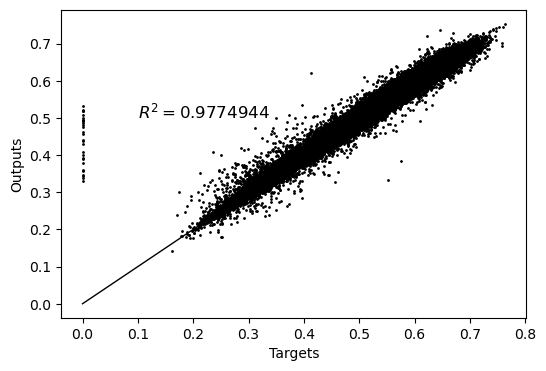

In [55]:
# Figure targets vs outputs
plt.figure(figsize=(6, 4))
plt.scatter(targets_clean, outputs_clean, color='black', s=1, label="Data")  
plt.plot([0, 0.6], [0, 0.6], color='black', linewidth=1)
plt.text(0.1, 0.5, f"$R^2 = {r2_score(outputs_clean, targets_clean):.7f}$", fontsize=12)

plt.xlabel("Targets")
plt.ylabel("Outputs")

# 7) Surface de Volatilité

In [56]:
r= 0.02
tau= 0.5
rho = -0.05
kappa= 1.5
theta = 0.1
gamma = 0.3
v0 = 0.1
moyeness = 0.7
moyeness = np.linspace(moyeness, 1.15, 11) 
tau = np.linspace(tau, 1, 6)

MC_prices = []
X = []
Y = []
for m in moyeness:
  for t in tau:
    X.append(m)
    Y.append(t)
    MC_prices.append(heston_monte_carlo(moneyness = m, r = r, tau = t, kappa = kappa, theta = theta, gamma = gamma, v0 = v0, rho = rho, M = 100000 , N = 1000 , device='cuda'))

MC_prices = np.array(MC_prices).reshape((-1, 1))
X = np.array(X).reshape((-1, 1))
Y = np.array(Y).reshape((-1, 1))
r = np.array(r*np.ones(66)).reshape((-1, 1))

In [57]:
data = np.concatenate((X, Y, r, MC_prices), axis = 1)
data = torch.FloatTensor(data)

In [58]:
with torch.no_grad():
  data = data.to(device)
  data[:,3] = data[:,3] - torch.maximum(data[:,0]-torch.exp(-data[:,1]*data[:,2]),torch.zeros(data[:,0].shape).to(device))
  data[:,3] = torch.log(data[:,3])
  output = loaded_IV_ANN(data)
  bs_IV = (output).data.cpu().numpy()

X = X.flatten()
Y = Y.flatten()
Z = bs_IV

x = np.reshape(X, (-1, 6))
y = np.reshape(Y, (-1, 6))
z = np.reshape(Z, (-1, 6))

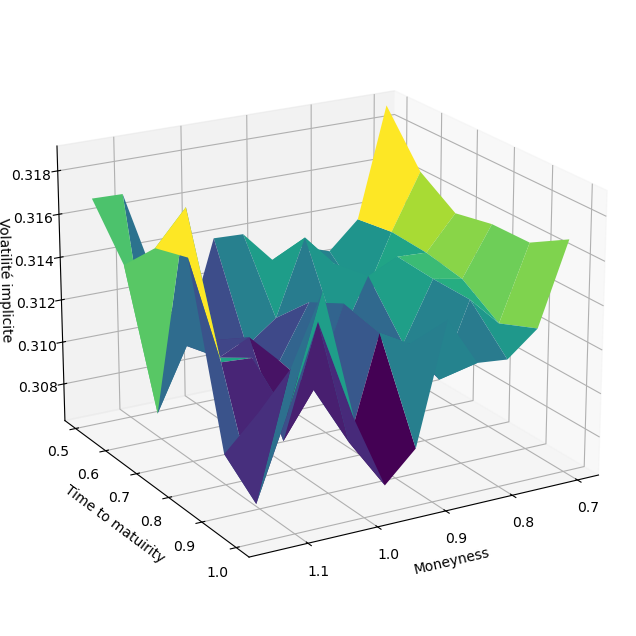

In [59]:
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.view_init(elev=20, azim=60)
ax.plot_surface(x, y, z,cmap='viridis', edgecolor='none', antialiased=True)
ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to matuirity')
ax.set_zlabel('Volatilité implicite')
plt.show()

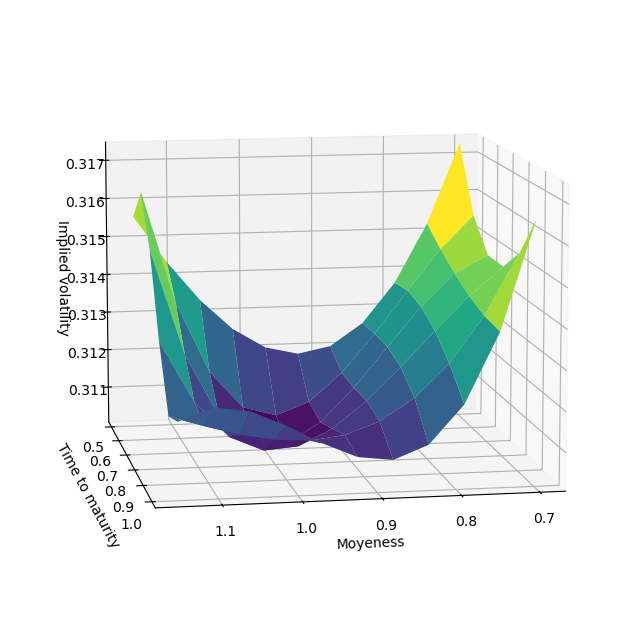

In [ ]:
# Une simple interpolation spline.
xnew, ynew = x.copy(), y.copy()
tck = interpolate.bisplrep(x, y, z, s=1.0)
znew = interpolate.bisplev(xnew[:,0], ynew[0,:], tck)

plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.view_init(elev=20, azim=80)
ax.plot_surface(xnew, ynew, znew,cmap='viridis', edgecolor='none', antialiased=True)
ax.set_xlabel('Moyeness')
ax.set_ylabel('Time to maturity')
ax.set_zlabel('Implied volatility')
plt.show()

>### Nous avons réalisé plusieurs tests afin de générer la surface de volatilité implicite la plus idéale. Ci-dessous, nous présentons les résultats des autres essais. Parmi ces derniers, nous avons sélectionné le plus satisfaisant pour l’inclure dans le rapport final.
>

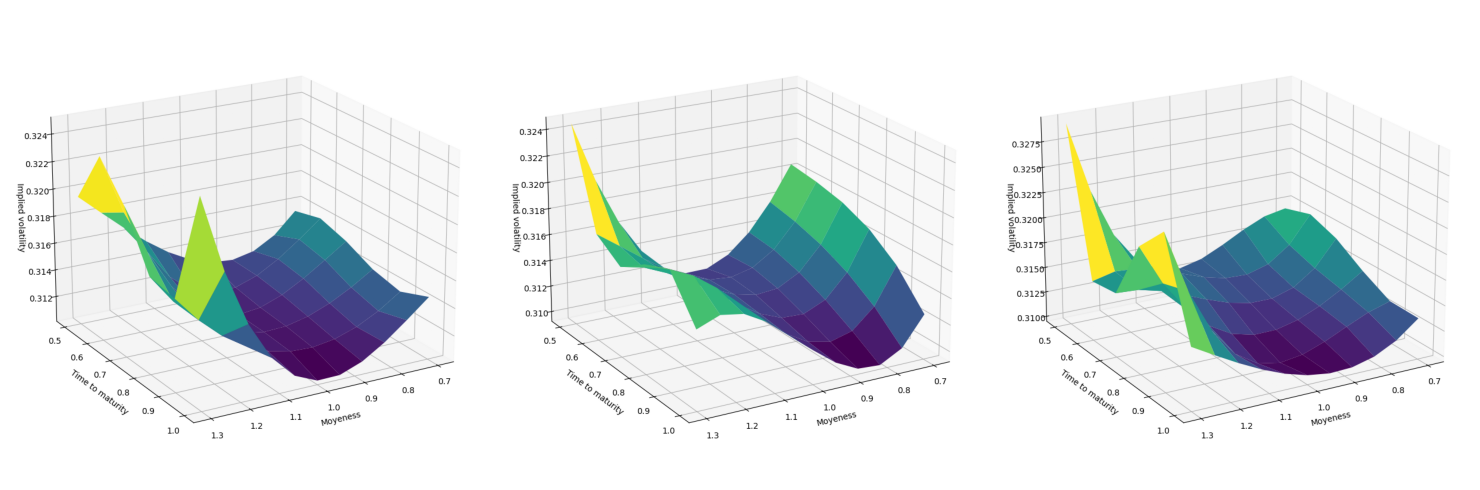

In [61]:
import matplotlib.image as mpimg

image_paths = [ 
               r'C:\Users\qiyao\OneDrive\Desktop\Documents\Documents_M2\ProbaNum avancée\Projet-reproduce\output2.png', 
               r'C:\Users\qiyao\OneDrive\Desktop\Documents\Documents_M2\ProbaNum avancée\Projet-reproduce\output3.png', 
               r'C:\Users\qiyao\OneDrive\Desktop\Documents\Documents_M2\ProbaNum avancée\Projet-reproduce\output4.png'] 

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  
for i, ax in enumerate(axes.flat):  
    img = mpimg.imread(image_paths[i])  
    ax.imshow(img)  
    ax.axis('off')  
    
plt.tight_layout()
plt.show()
